In [1]:
import torch

#Import models
from models.TimesNet import Model as TimesNet
from models.Nonstationary_Transformer import Model as NST
from models.Informer import Model as Informer

from tqdm import tqdm, trange

from torch.utils.data import DataLoader,TensorDataset
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import os
from datetime import datetime, timedelta
import time
import traceback
import subprocess
import re

In [2]:
# GPU handling
print(torch.__version__)
print(torch.version.cuda)
torch.cuda.is_available()
# Seeing that the GPU hase enough memory to run
print(torch.cuda.empty_cache())  # Frees unused memory
print(torch.cuda.memory_summary(device=None, abbreviated=False))  # Shows memory usage
print(torch.cuda.ipc_collect())

2.5.1
11.8
None
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool |      0 B   |      0 B   |      0 B   |      0 B   |
|       from small pool |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool |      0 B   |      0 B 

In [3]:
def get_least_used_gpu():
    """Find the GPU with the most available memory using nvidia-smi."""
    try:
        # Run nvidia-smi and get memory info
        result = subprocess.run(
            ["nvidia-smi", "--query-gpu=memory.free", "--format=csv,nounits,noheader"],
            stdout=subprocess.PIPE,
            text=True,
            check=True
        )
        
        # Parse output into a list of free memory values
        free_memory = [int(x) for x in result.stdout.strip().split("\n")]
        print(free_memory)
        
        # Find GPU with max free memory
        best_gpu = free_memory.index(max(free_memory))
        return best_gpu

    except Exception as e:
        print(f"Error getting GPU memory info: {e}")
        return 0  # Default to GPU 0 if there's an issue

# Get the best GPU with the most free memory
best_gpu = get_least_used_gpu()

# Set it for PyTorch
torch.cuda.set_device(best_gpu)
print(f"Using GPU: {torch.cuda.current_device()} (GPU {best_gpu})")

[1036, 11456, 19694]
Using GPU: 2 (GPU 2)


In [4]:
class TimeSeriesConfig:
    def __init__(self,
                 model_type='nst',
                 num_class=5,
                 seq_len=101,
                 num_features=1,
                 classes_names=['Google Doc', 'Google Drive', 'Google Music', 'Google Search', 'Youtube']
                ):
        # Common configurations for all models
        self.task_name = 'classification'
        self.seq_len = seq_len  # Your sequence length
        self.pred_len = 0   # Not used in classification
        self.label_len = 0  # Not used in classification
        
        # Input/Output dimensions
        self.enc_in = num_features      # Number of input features
        self.dec_in = 1      # Not used in classification
        self.c_out = 1       # Not used in classification
        self.num_class = num_class   # Number of classes
        
        # Training parameters
        self.dropout = 0.1
        self.embed = 'timeF'
        self.freq = 'h'
        self.batch_size = 32
        self.learning_rate = 1e-4
        self.num_epochs = 1 #10
        
        # Other configs
        self.use_gpu = True if torch.cuda.is_available() else False
        self.checkpoint_dir = 'checkpoints'
        self.classes_names = classes_names
        
        # Model specific configurations
        if model_type.lower() == 'nst':
            self._set_nst_config()
        elif model_type.lower() == 'timesnet':
            self._set_timesnet_config()
        elif model_type.lower() == 'informer':
            self._set_informer_config()
        else:
            raise ValueError(f"Unknown model type: {model_type}")
            
        self.model_name = f'{model_type.lower()}_classifier'
    
    def _set_nst_config(self):
        """Nonstationary Transformer specific configurations"""
        # Model architecture - Reduced dimensions
        self.d_model = 64      # Reduced from 256 to match TimesNet
        self.n_heads = 4       # Reduced from 8
        self.e_layers = 2
        self.d_layers = 1
        self.d_ff = 256       # Reduced from 2048
        self.factor = 5

        # Projector configs - Adjusted to match model size
        self.p_hidden_dims = [128, 64]  # Reduced from [256, 128]
        self.p_hidden_layers = 2

        # Embedding configs
        self.activation = 'gelu'
        self.output_attention = True
    
    def _set_timesnet_config(self):
        """TimesNet specific configurations"""
        # Model architecture
        self.d_model = 64
        self.e_layers = 2
        self.d_ff = 128
        
        # TimesNet specific
        self.top_k = 3
        self.num_kernels = 6
    
    def _set_informer_config(self):
        """Informer specific configurations"""
        # Model architecture
        self.d_model = 512
        self.n_heads = 8
        self.e_layers = 3
        self.d_layers = 2
        self.d_ff = 2048
        self.factor = 5  # probsparse factor
        self.distil = True  # whether to use distilling in encoder
        self.activation = 'gelu'
        self.embed = 'fixed'
        self.attn = 'prob'
        self.dropout = 0.05
        self.output_attention = False
        self.mix = True
        
    def print_config(self):
        """Print all configurations"""
        print("\nModel Configuration:")
        print("-" * 50)
        for attr, value in self.__dict__.items():
            print(f"{attr}: {value}")
        print("-" * 50)


In [5]:
def train_classifier(train_loader, val_loader, config, model=None, start_epoch=0, best_val_acc=0):
    """
    Train the TimesNet for classification
    """
    # Start timing
    total_start_time = time.time()
    
    # Initialize model if not provided
    if model is None:
        if config.model_name == 'timesnet_classifier':
            model = TimesNet(config)
        elif config.model_name == 'nst_classifier':
            model = NST(config)
        elif config.model_name == 'informer_classifier':
            model = Informer(config)
        else:
            print("Invalid model type")
            return None
        
    if config.use_gpu:
        model = model.cuda()
    
    # Define loss and optimizer
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
    
    # Initialize metrics storage
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    
#     # Training loop
#     for epoch in range(start_epoch, config.num_epochs):
#         epoch_start_time = time.time()
#         model.train()
#         total_loss = 0
#         correct = 0
#         total = 0
    # Training loop with progress bar for epochs
    epoch_pbar = trange(start_epoch, config.num_epochs, desc='Training')
    for epoch in epoch_pbar:
        epoch_start_time = time.time()
        model.train()
        total_loss = 0
        correct = 0
        total = 0
        
#         for batch_x, batch_y in train_loader:
        # Progress bar for batches within each epoch
        batch_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}', leave=False)
        for batch_x, batch_y in batch_pbar:
            optimizer.zero_grad()
            
            # Prepare data
            if config.use_gpu:
                batch_x = batch_x.float().cuda()
                batch_y = batch_y.long().cuda()
            
            # Create marking tensor with correct dimensions
            # batch_mark = torch.ones((batch_x.shape[0], batch_x.shape[1]), device=batch_x.device)
            
            # Forward pass
            outputs = model(
                x_enc=batch_x,
                x_mark_enc=None,#batch_mark,
                x_dec=None,
                x_mark_dec=None
            )
            
            loss = criterion(outputs, batch_y)
            
            if torch.isnan(loss):
                print("NaN detected!")
                print("Batch labels:", batch_y)
                return None,None
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()
            
            total_loss += loss.item()
            
            # Update batch progress bar
            batch_pbar.set_postfix({
               'loss': f'{loss.item():.4f}',
               'acc': f'{(correct/total)*100:.2f}%'
            })
        
        # Calculate training metrics
        avg_train_loss = total_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        train_losses.append(avg_train_loss)
        train_accs.append(train_accuracy)
        
        # Validation
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        
        val_pbar = tqdm(val_loader, desc='Validation', leave=False)
        
        with torch.no_grad():
            for batch_x, batch_y in val_pbar: #val_loader:
                if config.use_gpu:
                    batch_x = batch_x.float().cuda()
                    batch_y = batch_y.long().cuda()
                
                # batch_mark = torch.ones((batch_x.shape[0], batch_x.shape[1]), device=batch_x.device)
                
                outputs = model(
                    x_enc=batch_x,
                    x_mark_enc=None,#batch_mark,
                    x_dec=None,
                    x_mark_dec=None
                )
                
                loss = criterion(outputs, batch_y)
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs.data, 1)
                total += batch_y.size(0)
                correct += (predicted == batch_y).sum().item()
                
                # Update validation progress bar
                val_pbar.set_postfix({
                   'loss': f'{loss.item():.4f}',
                   'acc': f'{(correct/total)*100:.2f}%'
                })
        
        # Calculate validation metrics
        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * correct / total
        val_losses.append(avg_val_loss)
        val_accs.append(val_accuracy)
        
        # Save best model
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            save_checkpoint(
                model, optimizer, epoch, best_val_acc, config,
                f'{config.model_name}_best.pth'
            )

        # Save regular checkpoint
        if (epoch + 1) % 5 == 0:  # Save every 5 epochs
            save_checkpoint(
                model, optimizer, epoch, best_val_acc, config,
                f'{config.model_name}_epoch_{epoch+1}.pth'
            )

        # Calculate epoch time
        epoch_time = time.time() - epoch_start_time
        
        # Update epoch progress bar
        epoch_pbar.set_postfix({
           'train_loss': f'{avg_train_loss:.4f}',
           'train_acc': f'{train_accuracy:.2f}%',
           'val_loss': f'{avg_val_loss:.4f}',
           'val_acc': f'{val_accuracy:.2f}%',
           'time': f'{timedelta(seconds=int(epoch_time))}'
        })
        
        print(f'Epoch {epoch+1}/{config.num_epochs}')
        print(f'Training Loss: {avg_train_loss:.4f}, Accuracy: {train_accuracy:.2f}%')
        print(f'Validation Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy:.2f}%')
        print(f'Epoch time: {timedelta(seconds=epoch_time)}')
        print('----------------------------------------')
    
    # Calculate total training time
    total_time = time.time() - total_start_time
    print("\nTraining Complete!")
    print(f"Total training time: {timedelta(seconds=total_time)}")
    
    # Plot and save metrics
    plot_metrics(train_losses, val_losses, train_accs, val_accs, config)
    evaluate_model(model, val_loader, config)
    
    return model, best_val_acc


In [6]:
def prepare_data(X, y, config, val_split=0.2):
    batch_size=config.batch_size
    
    # Split data
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=val_split, random_state=32, stratify=y
    )
    
    # Create datasets
    train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.LongTensor(y_train))
    val_dataset = TensorDataset(torch.FloatTensor(X_val), torch.LongTensor(y_val))
    
    # Adjust DataLoader settings based on device
    loader_args = {
        'batch_size': batch_size,
        'num_workers': 4 if torch.cuda.is_available() else 2,
        'pin_memory': torch.cuda.is_available(),
    }
    
    train_loader = DataLoader(train_dataset, shuffle=True, **loader_args)
    val_loader = DataLoader(val_dataset, shuffle=False, **loader_args)
    
    return train_loader, val_loader

def plot_metrics(train_losses, val_losses, train_accs, val_accs, config):
    """Plot and save training metrics"""
    save_dir=config.checkpoint_dir
    try:
        # Create directory if it doesn't exist
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
            print(f"Created directory: {save_dir}")
        
        print("\nPlotting Training Metrics...")
        plt.figure(figsize=(12, 5))
        
        # Plot losses
        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label='Training Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        
        # Plot accuracies
        plt.subplot(1, 2, 2)
        plt.plot(train_accs, label='Training Accuracy')
        plt.plot(val_accs, label='Validation Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.legend()
        
        plt.tight_layout()
        
        
        # Save path with full directory
        save_path = os.path.join(save_dir, f'{config.model_name}_training_metrics.png')
        print(f"Saving metrics plot to: {save_path}")
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
        print("Successfully saved metrics plot")
        
        
        # Display the plot
        plt.show()
        
        #close
        plt.close()
        
    except Exception as e:
        print(f"Error in plotting metrics: {str(e)}")
        import traceback
        traceback.print_exc()

# def plot_confusion_matrix(y_true, y_pred, config):
#     """Plot and save confusion matrix"""
#     save_dir=config.checkpoint_dir
#     classes = config.classes_names
#     try:
#         # Create directory if it doesn't exist
#         if not os.path.exists(save_dir):
#             os.makedirs(save_dir)
#             print(f"Created directory: {save_dir}")
        
#         print(f"\nCreating confusion matrix...")
#         cm = confusion_matrix(y_true, y_pred)
        
#         plt.figure(figsize=(10, 8))
#         plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
#         plt.title('Confusion Matrix')
#         plt.colorbar()
        
#         # Add class labels
#         tick_marks = np.arange(len(classes))
#         plt.xticks(tick_marks, classes, rotation=45, ha='right')
#         plt.yticks(tick_marks, classes)
        
#         # Add text annotations
#         thresh = cm.max() / 2.
#         for i, j in np.ndindex(cm.shape):
#             plt.text(j, i, format(cm[i, j], 'd'),
#                     horizontalalignment="center",
#                     color="white" if cm[i, j] > thresh else "black")
        
#         plt.tight_layout()
#         plt.ylabel('True label')
#         plt.xlabel('Predicted label')
        
        
#         # Save path with full directory
#         save_path = os.path.join(save_dir, f'{config.model_name}_confusion_matrix.png')
#         print(f"Saving confusion matrix to: {save_path}")
#         plt.savefig(save_path, bbox_inches='tight', dpi=300)
#         print("Successfully saved confusion matrix")
        
#         # Display the plot
#         plt.show()
        
#         # Close
#         plt.close()
        
        
#     except Exception as e:
#         print(f"Error in plotting confusion matrix: {str(e)}")
#         import traceback
#         traceback.print_exc()

def plot_confusion_matrix(y_true, y_pred, config):
    """Plot and save confusion matrix (both raw and percentage-normalized)."""
    save_dir = config.checkpoint_dir
    classes = config.classes_names

    try:
        # Ensure save directory exists
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
            print(f"Created directory: {save_dir}")

        print("\nCreating confusion matrices...")
        
        # Compute confusion matrices
        cm = confusion_matrix(y_true, y_pred)
        cm_norm = cm.astype('float') / cm.sum(axis=1, keepdims=True)  # Normalize row-wise
        cm_norm_percent = cm_norm * 100  # Convert to percentages

        def plot_and_save(cm, title, filename, normalize=False):
            """Helper function to plot and save a confusion matrix."""
            try:
                plt.figure(figsize=(10, 8))
                plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
                plt.title(title)
                plt.colorbar()

                # Class labels
                tick_marks = np.arange(len(classes))
                plt.xticks(tick_marks, classes, rotation=45, ha='right')
                plt.yticks(tick_marks, classes)

                # Text annotations
                for i, j in np.ndindex(cm.shape):
                    value = cm[i, j]
                    if normalize:
                        plt.text(j, i, f"{value:.1f}%",  # Correct percentage formatting
                                 horizontalalignment="center",
                                 color="white" if value > cm.max() / 2 else "black")
                    else:
                        plt.text(j, i, f"{int(value)}",  # Raw count values
                                 horizontalalignment="center",
                                 color="white" if value > cm.max() / 2 else "black")

                plt.tight_layout()
                plt.ylabel('True label')
                plt.xlabel('Predicted label')

                # Save figure
                save_path = os.path.join(save_dir, filename)
                plt.savefig(save_path, bbox_inches='tight', dpi=300)
                print(f"Successfully saved: {save_path}")

                # Display the plot
                plt.show()
                plt.close()

            except Exception as e:
                print(f"Error in plotting {title}: {str(e)}")
                traceback.print_exc()

        # Plot and save raw confusion matrix
        plot_and_save(cm, "Confusion Matrix (Counts)", f"{config.model_name}_confusion_matrix.png", normalize=False)

        # Plot and save normalized confusion matrix in percentages
        plot_and_save(cm_norm_percent, "Confusion Matrix (Percentage)", f"{config.model_name}_confusion_matrix_percent.png", normalize=True)

    except Exception as e:
        print(f"Error in creating confusion matrices: {str(e)}")
        traceback.print_exc()
        
def save_checkpoint(model, optimizer, epoch, best_val_acc, config, filename):
    """Save model checkpoint"""
    # Create directory if it doesn't exist
    os.makedirs(config.checkpoint_dir, exist_ok=True)
    
    # Print for debugging
    print(f"Saving checkpoint to {os.path.join(config.checkpoint_dir, filename)}")
    
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch,
        'best_val_acc': best_val_acc,
        'config': config
    }
    
    try:
        torch.save(checkpoint, os.path.join(config.checkpoint_dir, filename))
        print(f"Successfully saved checkpoint")
    except Exception as e:
        print(f"Error saving checkpoint: {e}")

def load_checkpoint(checkpoint_path, model=None, optimizer=None):
    """Load model checkpoint"""
    checkpoint = torch.load(checkpoint_path)
    
    if model is None:
        config = checkpoint['config']
        model = Model(config)
        
    if optimizer is None:
        optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
    
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    return model, optimizer, checkpoint['epoch'], checkpoint['best_val_acc'], checkpoint['config']

def evaluate_model(model, val_loader, config):
    """
    Evaluate the model on test data
    
    Args:
        model: Trained model
        test_loader: DataLoader for test data
        config: Configuration object
        classes: List of class names (optional)
    """
    
    # Start timing
    start_time = time.time()
    
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            if config.use_gpu:
                batch_x = batch_x.float().cuda()
                batch_y = batch_y.long().cuda()
            
            # Create marking tensor with correct dimensions (batch_size, seq_len, 1)
            # batch_mark = torch.ones((batch_x.shape[0], batch_x.shape[1], batch_x.shape[2]), device=batch_x.device)

            outputs = model(
                x_enc=batch_x,
                x_mark_enc= None,#batch_mark,
                x_dec=None,
                x_mark_dec=None
            )
            
            _, predicted = torch.max(outputs.data, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())
    
    accuracy = 100 * correct / total
    print(f'Val Accuracy: {accuracy:.2f}%')
    
    end_time = time.time()
    eval_time = end_time - start_time
    
    # Plot confusion matrix
    plot_confusion_matrix(all_labels, all_preds, config)
    
    print(f"\nEvaluation Complete!")
    print(f"Total evaluation time: {timedelta(seconds=eval_time)}")
    
    return accuracy, eval_time

In [7]:
def drop_unused_features(df, num_features, pos):
    """
    Drops all columns except those at positions pos and then repeats for every num_features columns
    """
    # Get total number of columns
    total_cols = df.shape[1]
    # Calculate how many groups of 9 features we have
    num_groups = total_cols // num_features
    
    # Create a list of column indices to keep
    cols_to_keep = []
    for i in range(num_groups):
        inx = i * num_features + pos
        cols_to_keep.append(inx)
    
    # Keep only the selected columns
    df = df.iloc[:, cols_to_keep]
    reshaped_df = df.values.reshape(df.shape[0], df.shape[1], 1)
    
    return reshaped_df

def prepare_features(feature_path,
                     pos = 1,
                     num_features = 9 
                    ):
    feature_df = pd.read_csv(filepath_or_buffer=feature_path)
    X = drop_unused_features(feature_df, num_features, pos)
    return X

# feature_path = r'C:\Users\shach\Desktop\project FlowPic\big_project\QUIC Dataset\pretraining\Dataset\250ms\5\5 classes\features.csv'
# label_path = r'C:\Users\shach\Desktop\project FlowPic\big_project\QUIC Dataset\pretraining\Dataset\250ms\5\5 classes\labels.csv'
# feature_df = pd.read_csv(filepath_or_buffer=feature_path)
# label_df = pd.read_csv(filepath_or_buffer=label_path)

# reshaped_labels = label_df.values.reshape(-1)
# print(reshaped_labels.shape)

def prepare_labels(label_path):
    label_df = pd.read_csv(filepath_or_buffer=label_path)
    reshaped_labels = label_df.values.reshape(-1)
    # Extract just the first number from each label string
    cleaned = np.array([int(label.split()[1]) for label in reshaped_labels])
    y = cleaned.astype(np.int64)
    if len(y.shape) > 1:
        y = y.ravel()  # Flatten if needed
    return y

# # pos = 1
# # num_features = 9 
# X = prepare_features(feature_path)

# y = prepare_label(label_path)  # Convert to int64 for PyTorch's CrossEntropyLoss

# print(X.shape)
# print(y.shape)
# # print(y.shape)
# # print(y)
# # print(X)


In [8]:
def get_classes_names(num_class):
    """
    Returns list of class names based on number of classes
    """
    class_names_dict = {
        5: ['Google Doc', 'Google Drive', 'Google Music', 'Google Search', 'Youtube'],
        4: ['Google Doc', 'Google Drive', 'Google Search', 'Youtube'],
        3: ['Google Doc', 'Google Drive', 'Youtube'],
    }
    
    # Default case
    if num_class not in class_names_dict:
        return [f'Class_{i}' for i in range(num_class)]
    
    return class_names_dict[num_class]

In [9]:
def get_data_parameters(X,y):
    num_class=len(np.unique(y))
    seq_len=X.shape[1]
    num_features=X.shape[2]
    classes_names=get_classes_names(num_class)
#     print('num_class: ', num_class,'\nseq_len: ', seq_len,'\nnum_features: ', num_features,'\nclasses_names: ', classes_names)
    return num_class, seq_len, num_features, classes_names

In [10]:
# model_type='nst'
# num_class, seq_len, num_features, classes_names = get_data_parameters(X,y)

# classes_names=get_classes_names(num_class)

In [11]:
# Usage example:
def create_model(X,y,config_type='nst'):
    """Create model with specified configuration"""
    num_class, seq_len, num_features, classes_names =get_data_parameters(X,y)
    config = TimeSeriesConfig(model_type=config_type,
                              num_class=num_class,
                              seq_len=seq_len,
                              num_features=num_features,
                              classes_names=classes_names
                             )
    
    if config.model_name == 'timesnet_classifier':
            model = TimesNet(config)
    elif config.model_name == 'nst_classifier':
        model = NST(config)
    elif config.model_name == 'informer_classifier':
        model = Informer(config)
    else:
        print("Invalid model type")
        return None
    return model, config



In [12]:
import pandas as pd
import os
from datetime import datetime

def evaluate_models_on_datasets(datasets_dict, model_types=['nst', 'timesnet', 'informer']):
    """
    Pipeline for evaluating multiple models on multiple datasets
    
    Args:
        datasets_dict: Dictionary with format {dataset_name: (X, y)}
        model_types: List of model types to evaluate
    """
    # Initialize results dictionary
    results = {
        'Model': [],
        'Dataset': [],
        'Train Accuracy': [],
        'Val Accuracy': [],
        'Training Time': [],
        'Inference Time': [] 
#        'Best Epoch': []
    }
    
    # Loop through each model type
    for model_type in model_types:
        print(f"\nEvaluating {model_type.upper()} model across datasets...")
        
        # Loop through each dataset
        for dataset_name, (X, y) in datasets_dict.items():
            # Create model and get config
            model, config = create_model(X, y, model_type)
            print(f"\nProcessing dataset: {dataset_name}")
            
            try:
                # Prepare data
                train_loader, val_loader = prepare_data(X, y, config)
                
                # Train model and time it
                start_time = time.time()
                model, best_val_acc = train_classifier(train_loader, val_loader, config, model=model)
                training_time = time.time() - start_time
                
                # Get final training accuracy
                train_acc, eval_time = evaluate_model(model, train_loader, config)
                
                # Store results
                results['Model'].append(model_type)
                results['Dataset'].append(dataset_name)
                results['Train Accuracy'].append(f"{train_acc:.2f}%")
                results['Val Accuracy'].append(f"{best_val_acc:.2f}%")
                results['Training Time'].append(str(timedelta(seconds=int(training_time)))) #
                results['Inference Time'].append(str(timedelta(seconds=int(eval_time))))
                #results['Best Epoch'].append(len(train_acc_history))
                
            except Exception as e:
                print(f"Error processing {dataset_name} with {model_type}: {str(e)}")
                # Store error in results
                results['Model'].append(model_type)
                results['Dataset'].append(dataset_name)
                results['Train Accuracy'].append("Error")
                results['Val Accuracy'].append("Error")
                results['Training Time'].append("Error") #
                results['Inference Time'].append("Error")
#                results['Best Epoch'].append("Error")

    # Create DataFrame from results
    df_results = pd.DataFrame(results)
    
    # Pivot table to get models as rows and datasets as columns
    df_pivot = df_results.pivot(index='Model', columns='Dataset', values='Val Accuracy')
    
    # Save results
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    os.makedirs('results', exist_ok=True)
    
    # Save both DataFrames as CSV files
    summary_path = f'results/model_comparison_summary_{timestamp}.csv'
    detailed_path = f'results/model_comparison_detailed_{timestamp}.csv'
    
    # Save pivot table (summary results)
    df_pivot.to_csv(summary_path)
    
    # Save detailed results
    df_results.to_csv(detailed_path, index=False)
    
    print(f"\nResults saved to:")
    print(f"Summary: {summary_path}")
    print(f"Detailed: {detailed_path}")
    
    return df_pivot

In [13]:
# """Prepare all the 3 classes Datasets"""
# def prepare_datasets():
#     datasets_dict = {}
    
#     # Dataset 1
#     feature_path1 = r"C:\Users\shach\Desktop\project FlowPic\big_project\QUIC Dataset\pretraining\Dataset\5ms\10\3 classes (without g.m & g.s)\features.csv"
#     label_path1 = r"C:\Users\shach\Desktop\project FlowPic\big_project\QUIC Dataset\pretraining\Dataset\5ms\10\3 classes (without g.m & g.s)/labels.csv"
#     X1 = prepare_features(feature_path1)
#     y1 = prepare_labels(label_path1)
#     datasets_dict[f'{X1.shape[1]}'] = (X1, y1)
#     print("Dataset 1: ",X1.shape[1])
#     # Dataset 2
#     feature_path2 = r"C:\Users\shach\Desktop\project FlowPic\big_project\QUIC Dataset\pretraining\Dataset\50ms\10\3 classes (without g.m & g.s)\features.csv"
#     label_path2 = r"C:\Users\shach\Desktop\project FlowPic\big_project\QUIC Dataset\pretraining\Dataset\50ms\10\3 classes (without g.m & g.s)\labels.csv"
#     X2 = prepare_features(feature_path2)
#     y2 = prepare_labels(label_path2)
#     datasets_dict[f'{X2.shape[1]}'] = (X2, y2)
#     print("Dataset 2: ",X2.shape[1])
#     # Dataset 3
#     feature_path3 = r"C:\Users\shach\Desktop\project FlowPic\big_project\QUIC Dataset\pretraining\Dataset\250ms\10\3 classes (without g.m & g.s)\features.csv"
#     label_path3 = r"C:\Users\shach\Desktop\project FlowPic\big_project\QUIC Dataset\pretraining\Dataset\250ms\10\3 classes (without g.m & g.s)\labels.csv"
#     X3 = prepare_features(feature_path3)
#     y3 = prepare_labels(label_path3)
#     datasets_dict[f'{X3.shape[1]}'] = (X3, y3)
#     print("Dataset 3: ",X3.shape[1])
    
#     return datasets_dict

In [14]:
"""Prepare all the 3 classes Datasets"""
def prepare_datasets():
    datasets_dict = {}
    
    # Dataset 1
    feature_path1 = r"/home/chanan/Dataset/5ms/10/3 classes (without g.m & g.s)/features.csv"
    label_path1 = r"/home/chanan/Dataset/5ms/10/3 classes (without g.m & g.s)/labels.csv"
    X1 = prepare_features(feature_path1)
    y1 = prepare_labels(label_path1)
    datasets_dict[f'{X1.shape[1]}'] = (X1, y1)
    print("Dataset 1: ",X1.shape[1])
    # Dataset 2
    feature_path2 = r"/home/chanan/Dataset/50ms/10/3 classes (without g.m & g.s)/features.csv"
    label_path2 = r"/home/chanan/Dataset/50ms/10/3 classes (without g.m & g.s)/labels.csv"
    X2 = prepare_features(feature_path2)
    y2 = prepare_labels(label_path2)
    datasets_dict[f'{X2.shape[1]}'] = (X2, y2)
    print("Dataset 2: ",X2.shape[1])
    # Dataset 3
    feature_path3 = r"/home/chanan/Dataset/250ms/10/3 classes (without g.m & g.s)/features.csv"
    label_path3 = r"/home/chanan/Dataset/250ms/10/3 classes (without g.m & g.s)/labels.csv"
    X3 = prepare_features(feature_path3)
    y3 = prepare_labels(label_path3)
    datasets_dict[f'{X3.shape[1]}'] = (X3, y3)
    print("Dataset 3: ",X3.shape[1])
    
    return datasets_dict

In [15]:
# Use the pipeline
datasets = prepare_datasets()

Dataset 1:  2001
Dataset 2:  201
Dataset 3:  41



Evaluating NST model across datasets...

Processing dataset: 2001


Training:   0%|          | 0/1 [00:00<?, ?it/s]


NaN detected!
Batch labels: tensor([1, 0, 1, 0, 1, 2, 2, 2, 0, 0, 1, 0, 1, 2, 1, 2, 0, 1, 1, 0, 0, 0, 0, 0,
        2, 0, 2, 2, 2, 1, 0, 0], device='cuda:2')
Error processing 2001 with nst: 'NoneType' object has no attribute 'eval'

Processing dataset: 201


Training:   0%|          | 0/1 [00:00<?, ?it/s]


NaN detected!
Batch labels: tensor([0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 2, 2, 1, 1, 0, 1, 2, 1, 0, 2, 1, 0, 1, 0,
        2, 2, 2, 1, 0, 0, 1, 1], device='cuda:2')
Error processing 201 with nst: 'NoneType' object has no attribute 'eval'

Processing dataset: 41


Training:   0%|          | 0/1 [00:00<?, ?it/s]

NaN detected!
Batch labels: tensor([0, 0, 1, 1, 0, 2, 2, 0, 2, 2, 2, 1, 2, 0, 2, 0, 1, 1, 2, 1, 2, 0, 0, 2,
        0, 1, 2, 2, 0, 2, 1, 2], device='cuda:2')
Error processing 41 with nst: 'NoneType' object has no attribute 'eval'

Evaluating INFORMER model across datasets...

Processing dataset: 2001



Training:   0%|          | 0/1 [00:00<?, ?it/s]

Saving checkpoint to checkpoints/informer_classifier_best.pth


Training: 100%|██████████| 1/1 [00:47<00:00, 47.90s/it, train_loss=2.1260, train_acc=86.59%, val_loss=0.6138, val_acc=89.89%, time=0:00:47]

Successfully saved checkpoint
Epoch 1/1
Training Loss: 2.1260, Accuracy: 86.59%
Validation Loss: 0.6138, Accuracy: 89.89%
Epoch time: 0:00:47.896692
----------------------------------------

Training Complete!
Total training time: 0:00:47.939128

Plotting Training Metrics...
Saving metrics plot to: checkpoints/informer_classifier_training_metrics.png


Successfully saved metrics plot


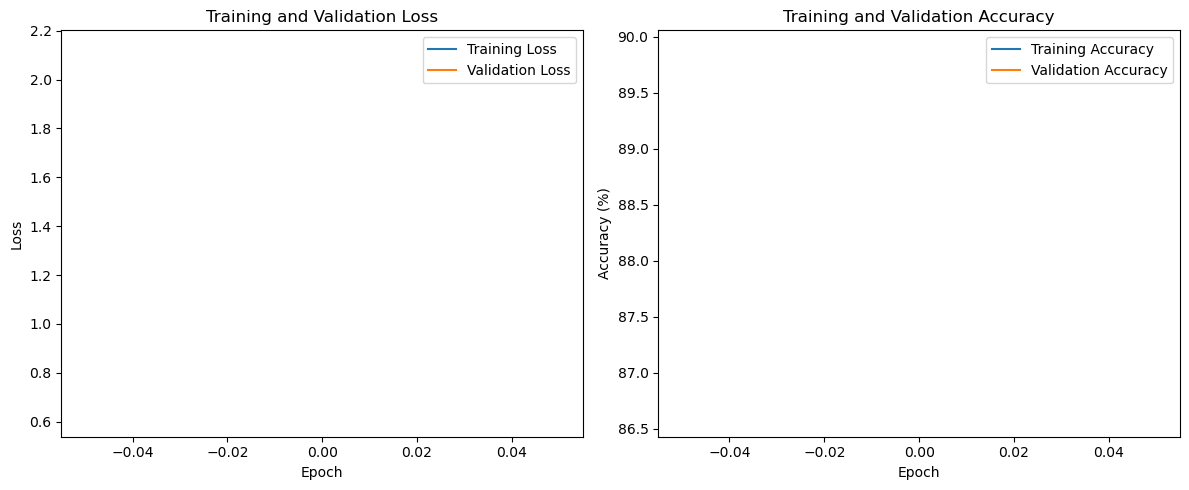

Val Accuracy: 89.63%

Creating confusion matrices...
Successfully saved: checkpoints/informer_classifier_confusion_matrix.png


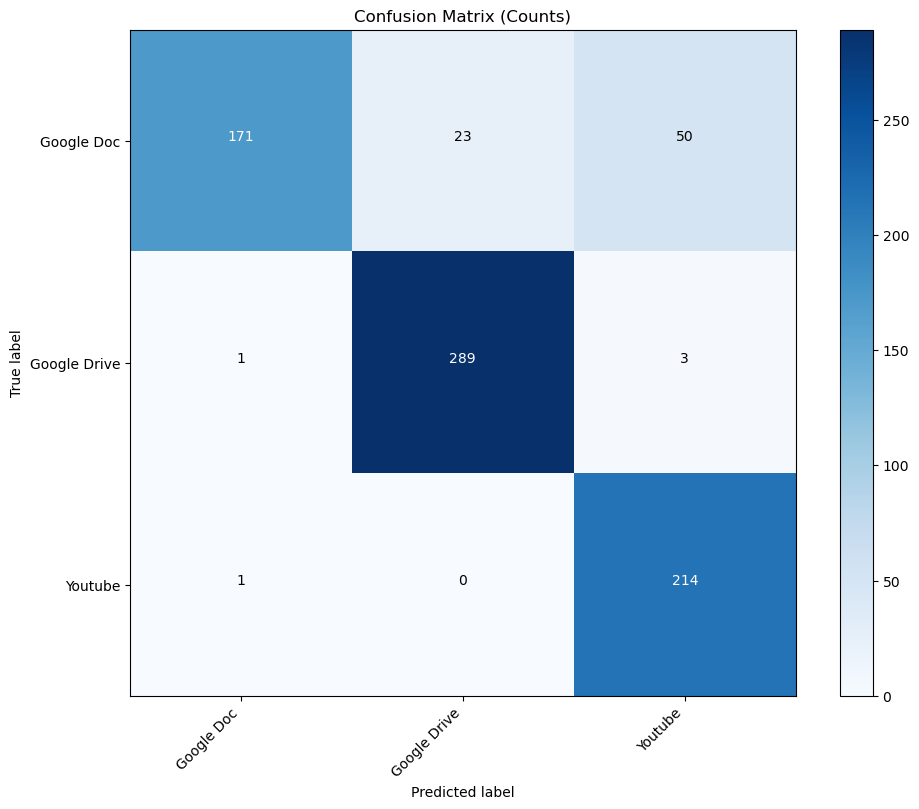

Successfully saved: checkpoints/informer_classifier_confusion_matrix_percent.png


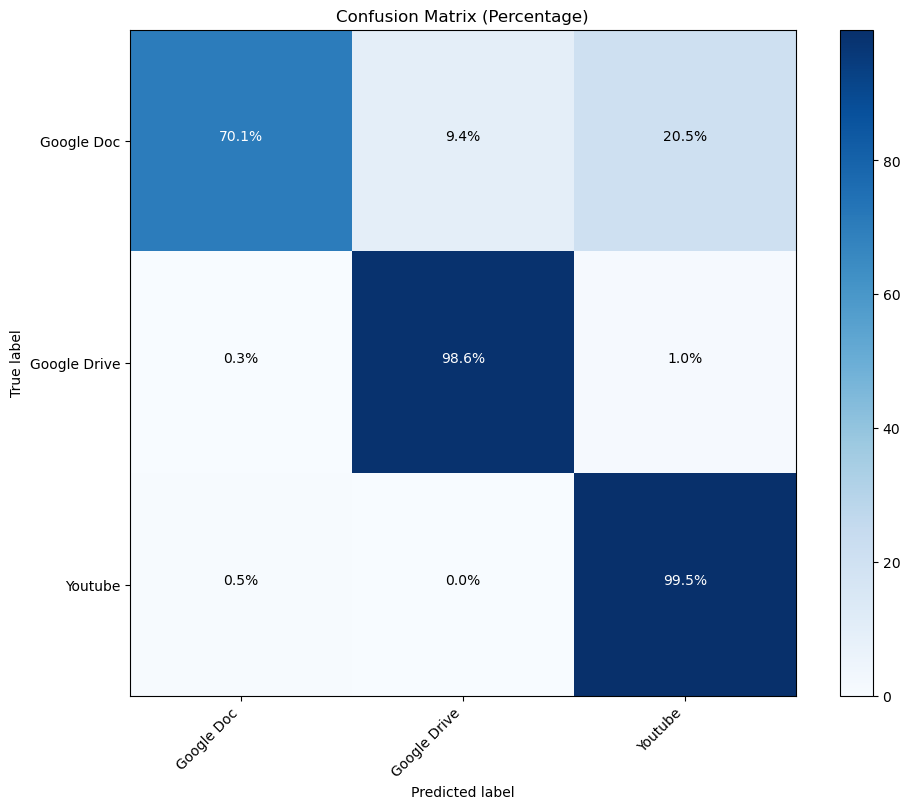


Evaluation Complete!
Total evaluation time: 0:00:05.105342
Val Accuracy: 92.45%

Creating confusion matrices...
Successfully saved: checkpoints/informer_classifier_confusion_matrix.png


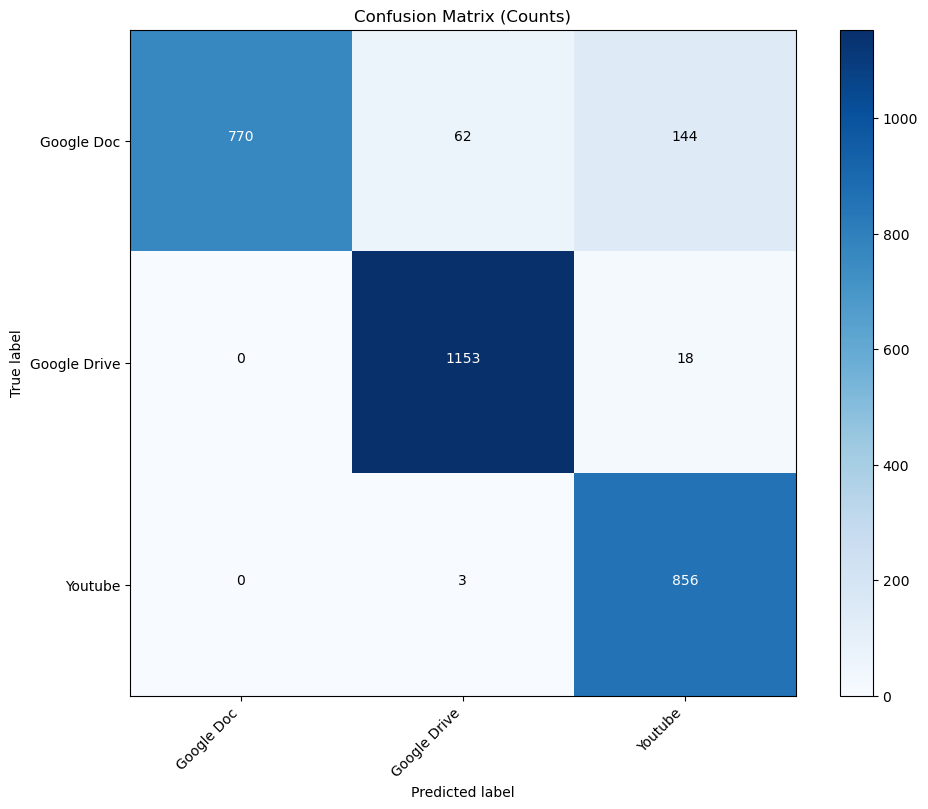

Successfully saved: checkpoints/informer_classifier_confusion_matrix_percent.png


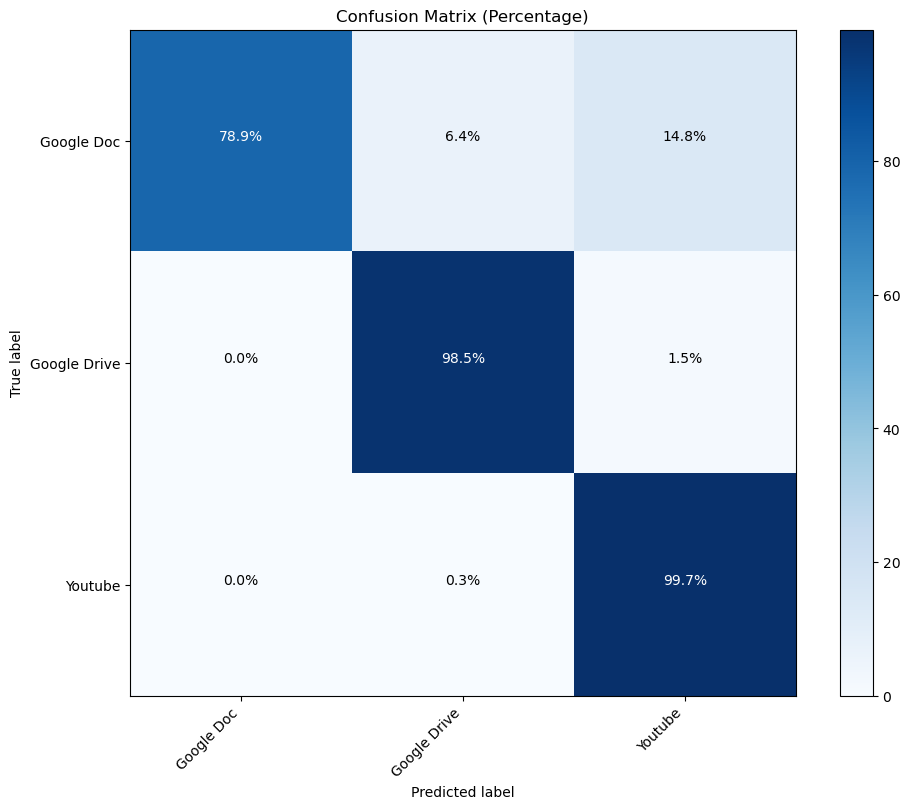


Evaluation Complete!
Total evaluation time: 0:00:19.570610

Processing dataset: 201


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Saving checkpoint to checkpoints/informer_classifier_best.pth


Training: 100%|██████████| 1/1 [00:06<00:00,  6.86s/it, train_loss=0.2140, train_acc=93.31%, val_loss=0.1032, val_acc=96.94%, time=0:00:06]

Successfully saved checkpoint
Epoch 1/1
Training Loss: 0.2140, Accuracy: 93.31%
Validation Loss: 0.1032, Accuracy: 96.94%
Epoch time: 0:00:06.856733
----------------------------------------

Training Complete!
Total training time: 0:00:06.884050

Plotting Training Metrics...
Saving metrics plot to: checkpoints/informer_classifier_training_metrics.png


Successfully saved metrics plot


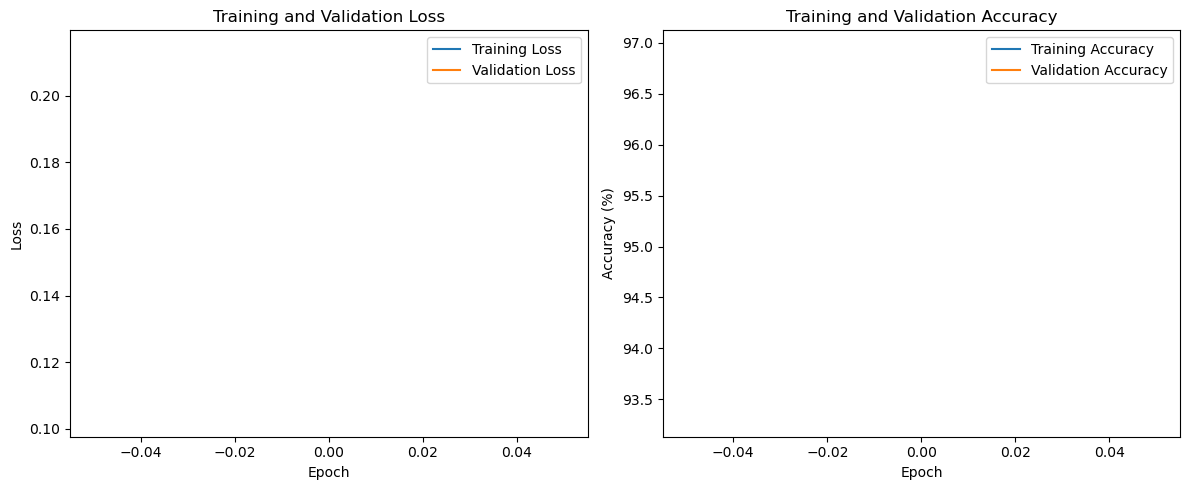

Val Accuracy: 96.28%

Creating confusion matrices...
Successfully saved: checkpoints/informer_classifier_confusion_matrix.png


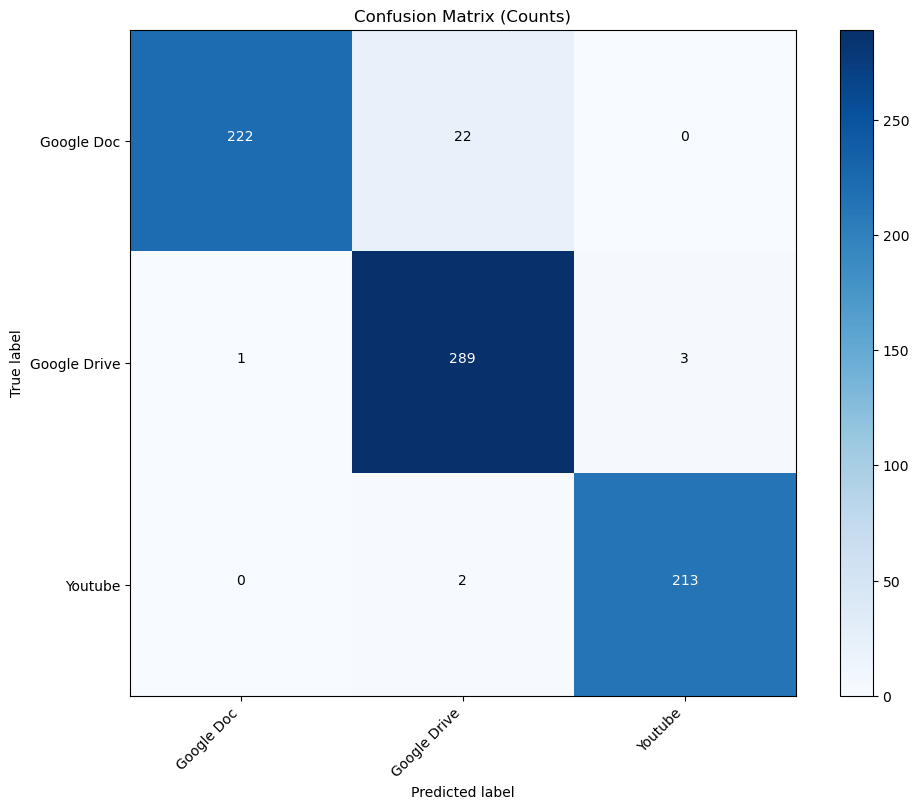

Successfully saved: checkpoints/informer_classifier_confusion_matrix_percent.png


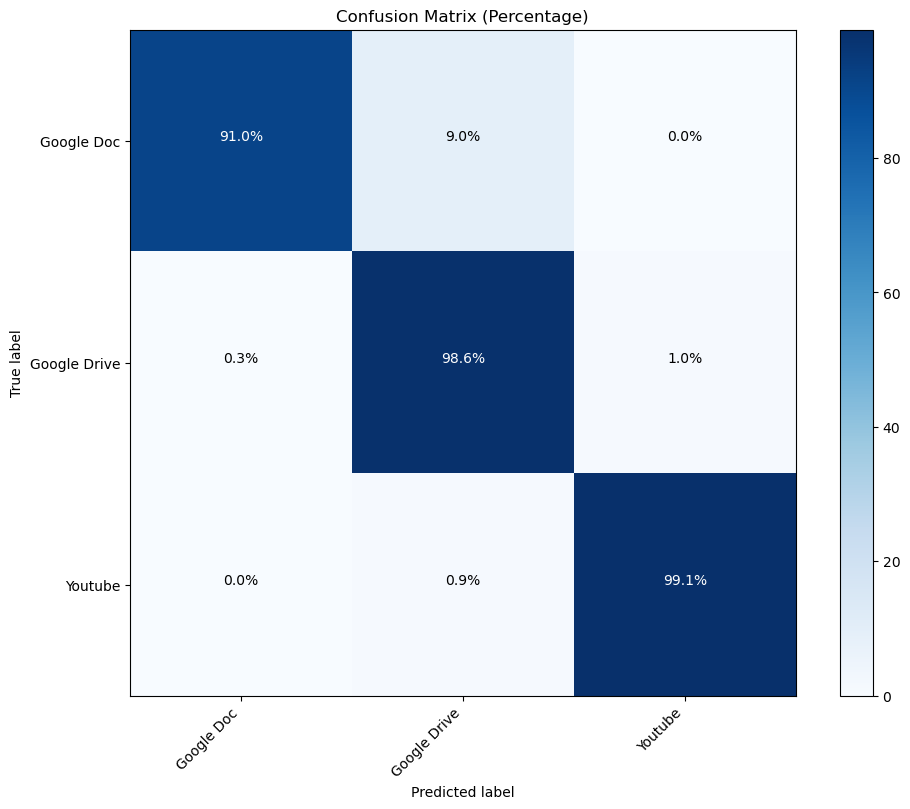


Evaluation Complete!
Total evaluation time: 0:00:00.738422
Val Accuracy: 98.14%

Creating confusion matrices...
Successfully saved: checkpoints/informer_classifier_confusion_matrix.png


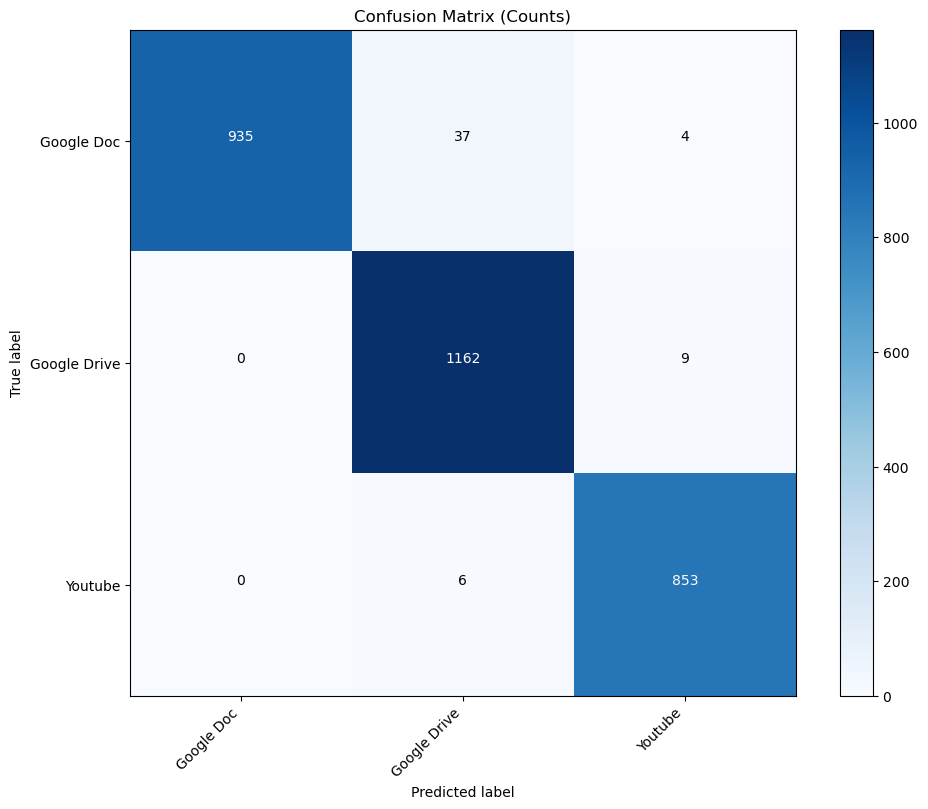

Successfully saved: checkpoints/informer_classifier_confusion_matrix_percent.png


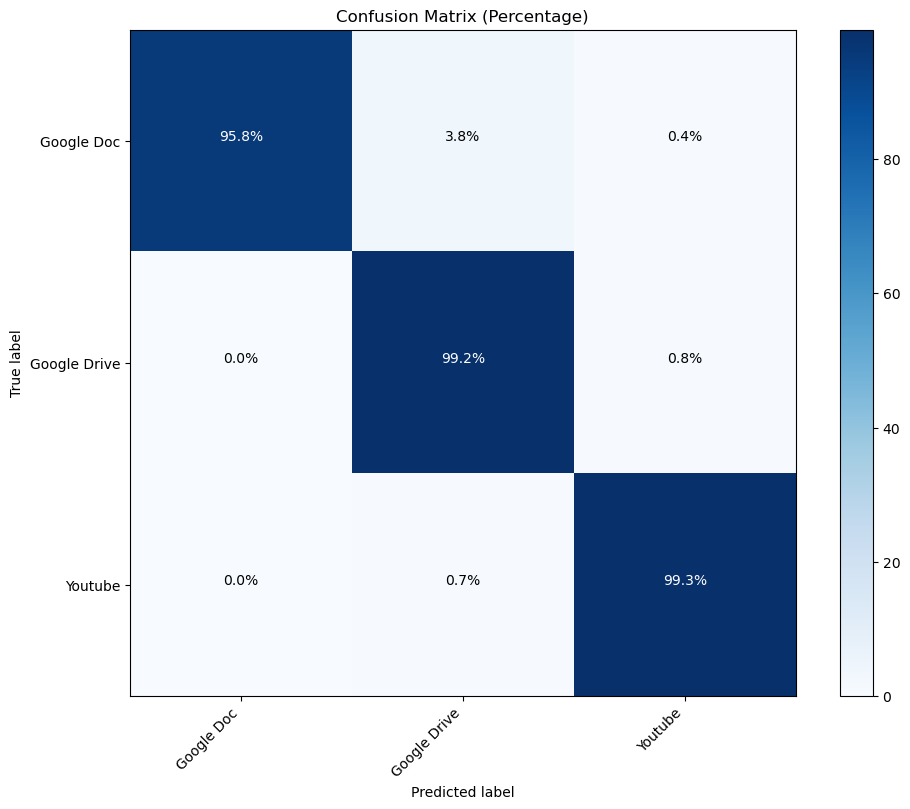


Evaluation Complete!
Total evaluation time: 0:00:02.195518

Processing dataset: 41


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Saving checkpoint to checkpoints/informer_classifier_best.pth


Training: 100%|██████████| 1/1 [00:04<00:00,  4.95s/it, train_loss=0.1581, train_acc=95.81%, val_loss=0.0754, val_acc=97.87%, time=0:00:04]

Successfully saved checkpoint
Epoch 1/1
Training Loss: 0.1581, Accuracy: 95.81%
Validation Loss: 0.0754, Accuracy: 97.87%
Epoch time: 0:00:04.945928
----------------------------------------

Training Complete!
Total training time: 0:00:04.972802

Plotting Training Metrics...
Saving metrics plot to: checkpoints/informer_classifier_training_metrics.png


Successfully saved metrics plot


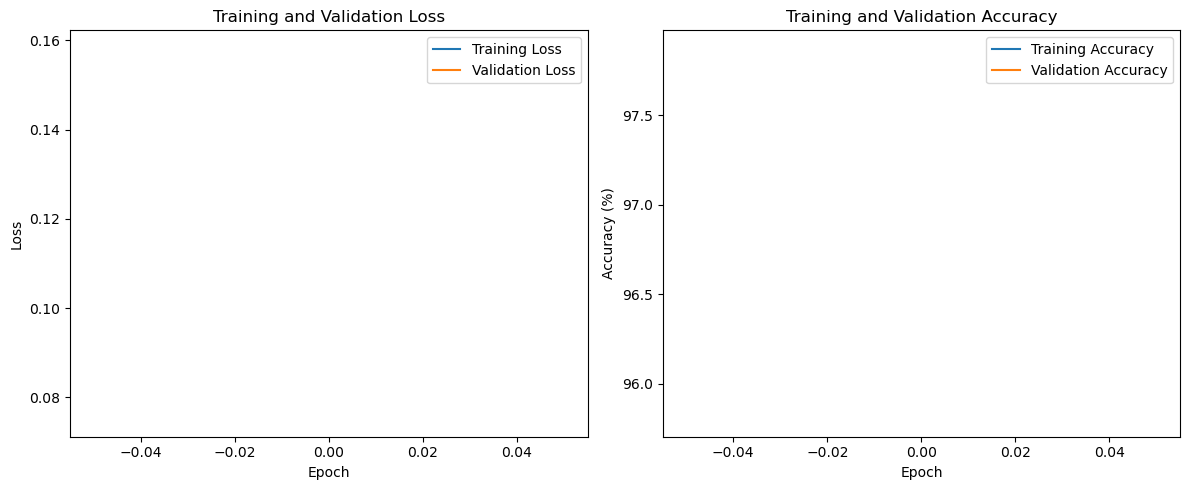

Val Accuracy: 97.74%

Creating confusion matrices...
Successfully saved: checkpoints/informer_classifier_confusion_matrix.png


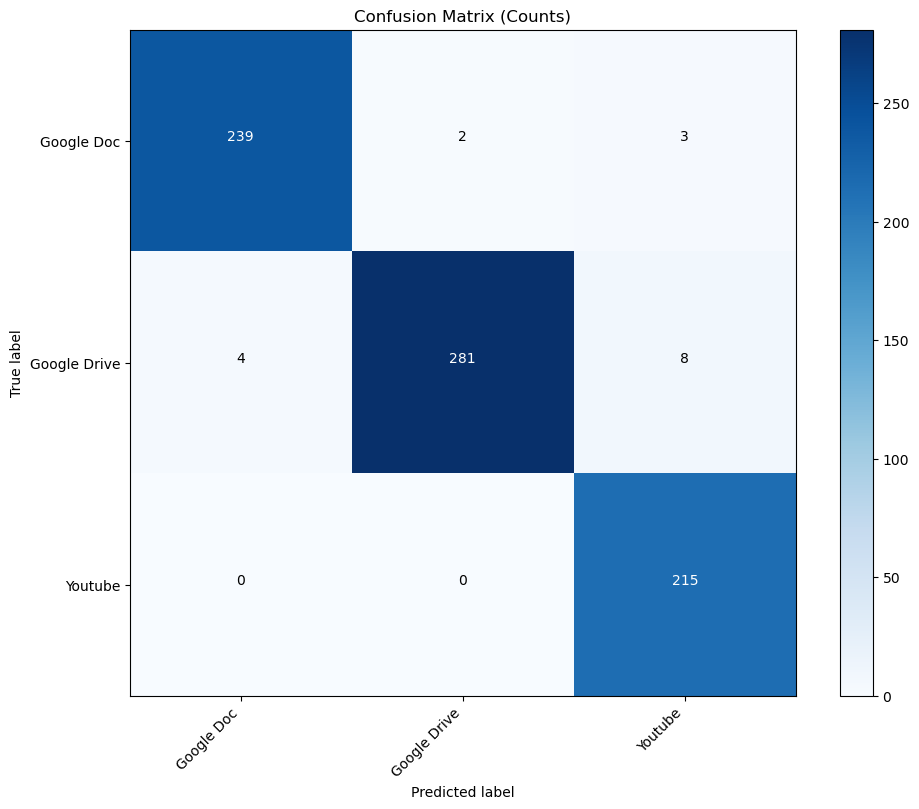

Successfully saved: checkpoints/informer_classifier_confusion_matrix_percent.png


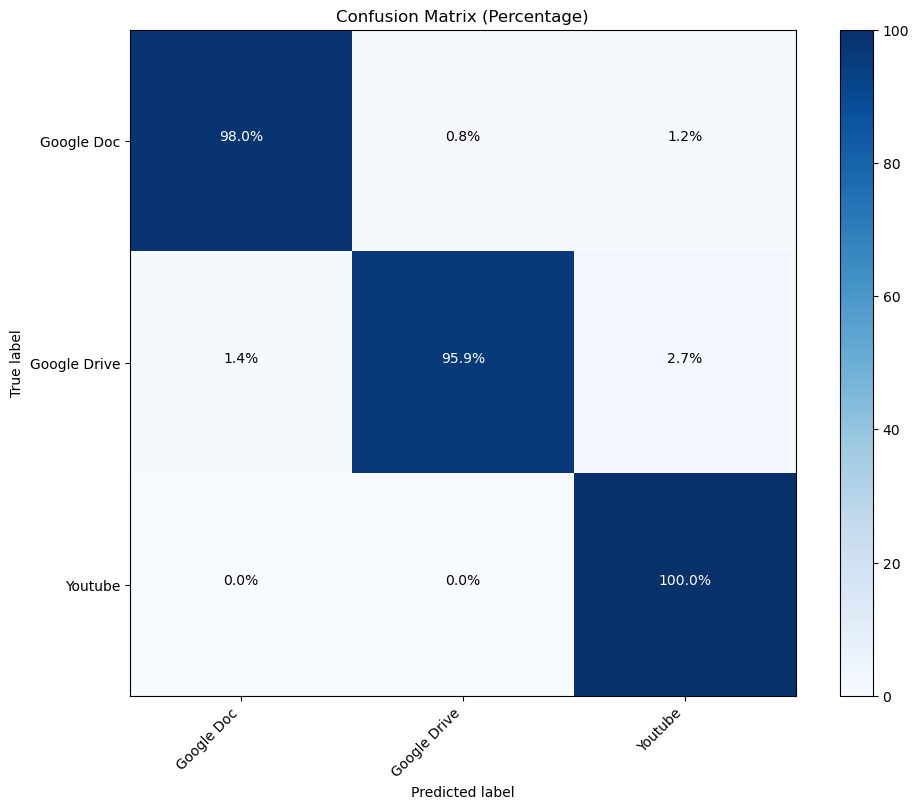


Evaluation Complete!
Total evaluation time: 0:00:00.430506
Val Accuracy: 97.67%

Creating confusion matrices...
Successfully saved: checkpoints/informer_classifier_confusion_matrix.png


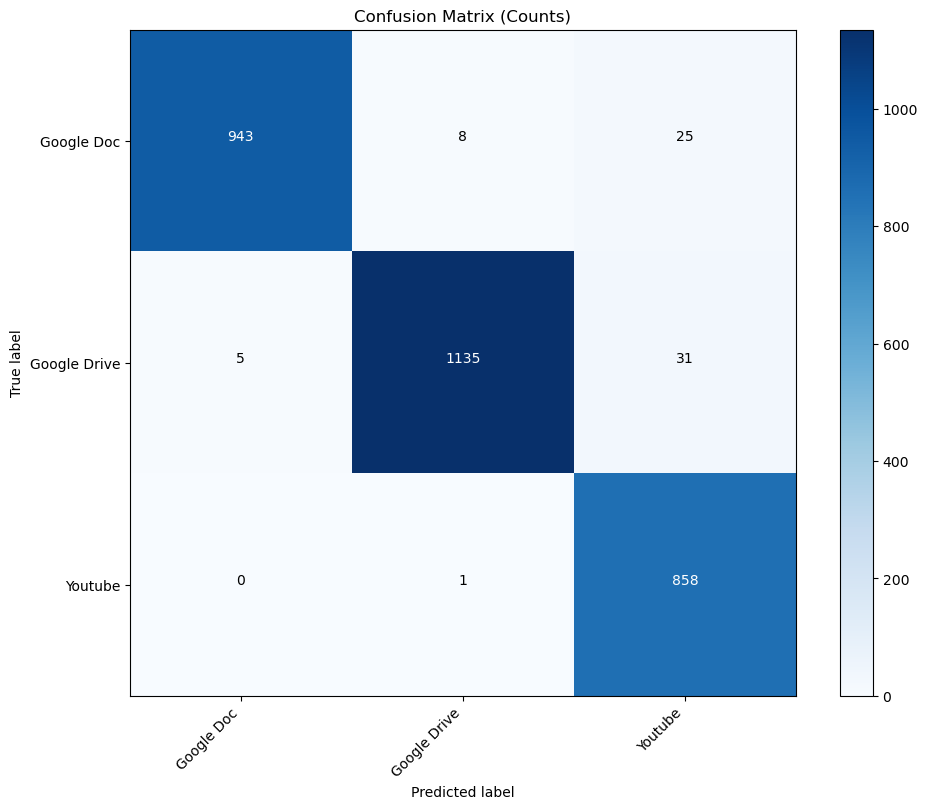

Successfully saved: checkpoints/informer_classifier_confusion_matrix_percent.png


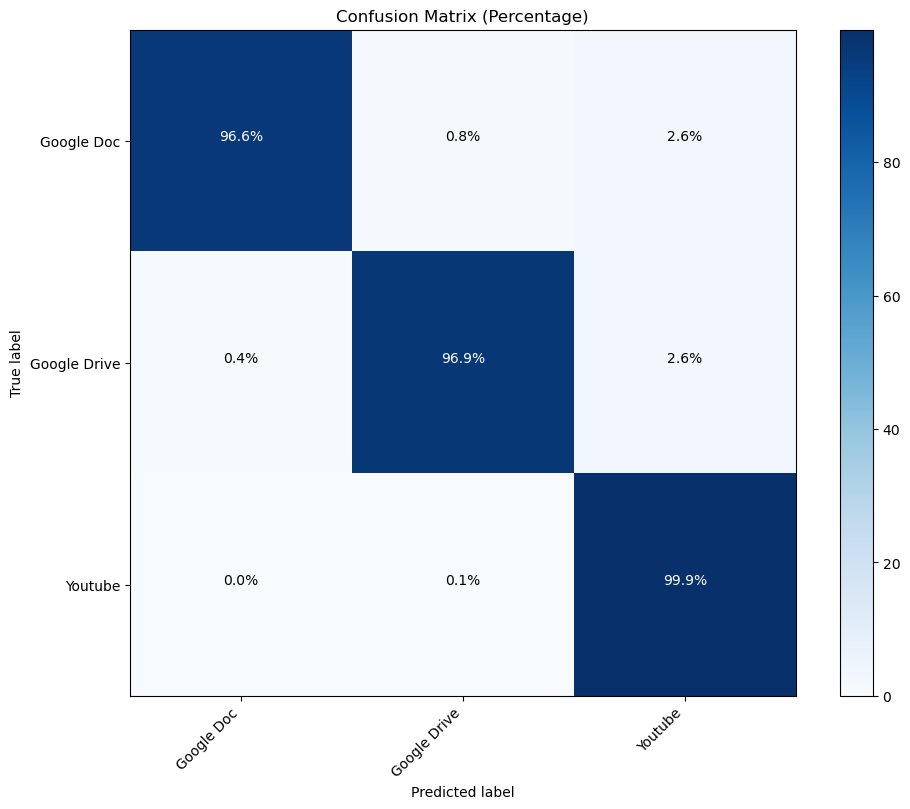


Evaluation Complete!
Total evaluation time: 0:00:00.975156

Evaluating TIMESNET model across datasets...

Processing dataset: 2001


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Saving checkpoint to checkpoints/timesnet_classifier_best.pth


Training: 100%|██████████| 1/1 [01:12<00:00, 72.67s/it, train_loss=0.2975, train_acc=90.35%, val_loss=0.1200, val_acc=96.41%, time=0:01:12]

Successfully saved checkpoint
Epoch 1/1
Training Loss: 0.2975, Accuracy: 90.35%
Validation Loss: 0.1200, Accuracy: 96.41%
Epoch time: 0:01:12.661578
----------------------------------------

Training Complete!
Total training time: 0:01:12.678973

Plotting Training Metrics...
Saving metrics plot to: checkpoints/timesnet_classifier_training_metrics.png


Successfully saved metrics plot


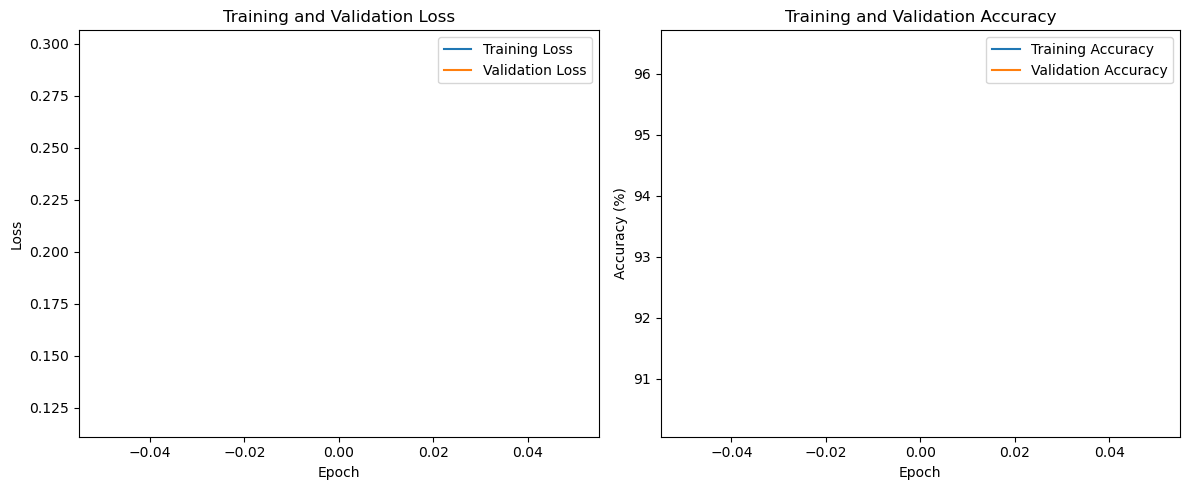

Val Accuracy: 96.41%

Creating confusion matrices...
Successfully saved: checkpoints/timesnet_classifier_confusion_matrix.png


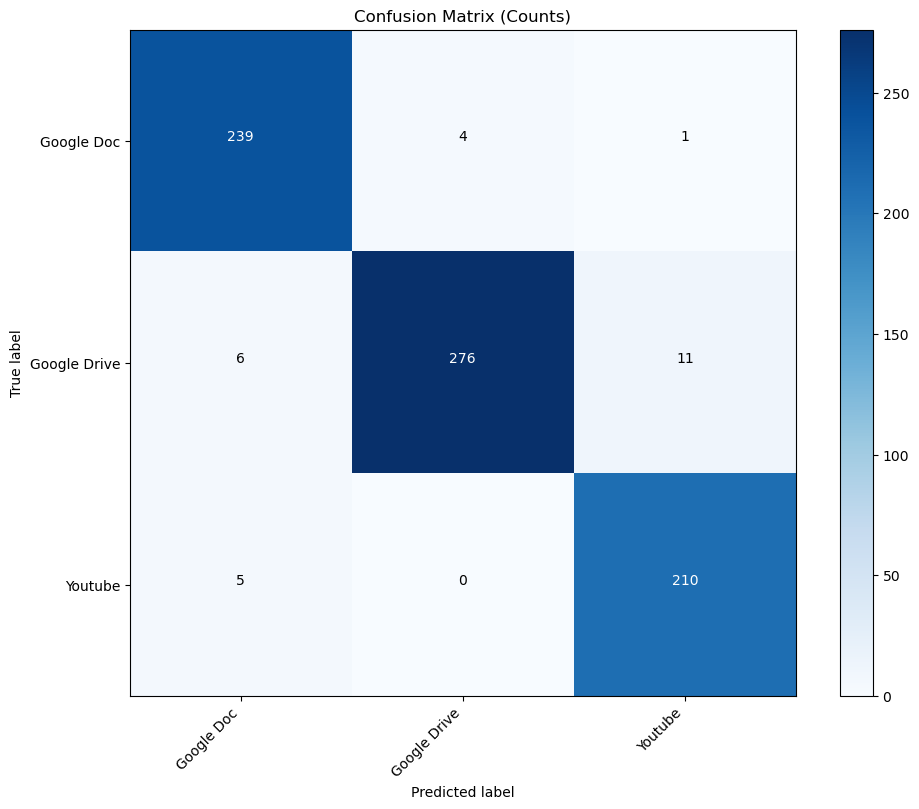

Successfully saved: checkpoints/timesnet_classifier_confusion_matrix_percent.png


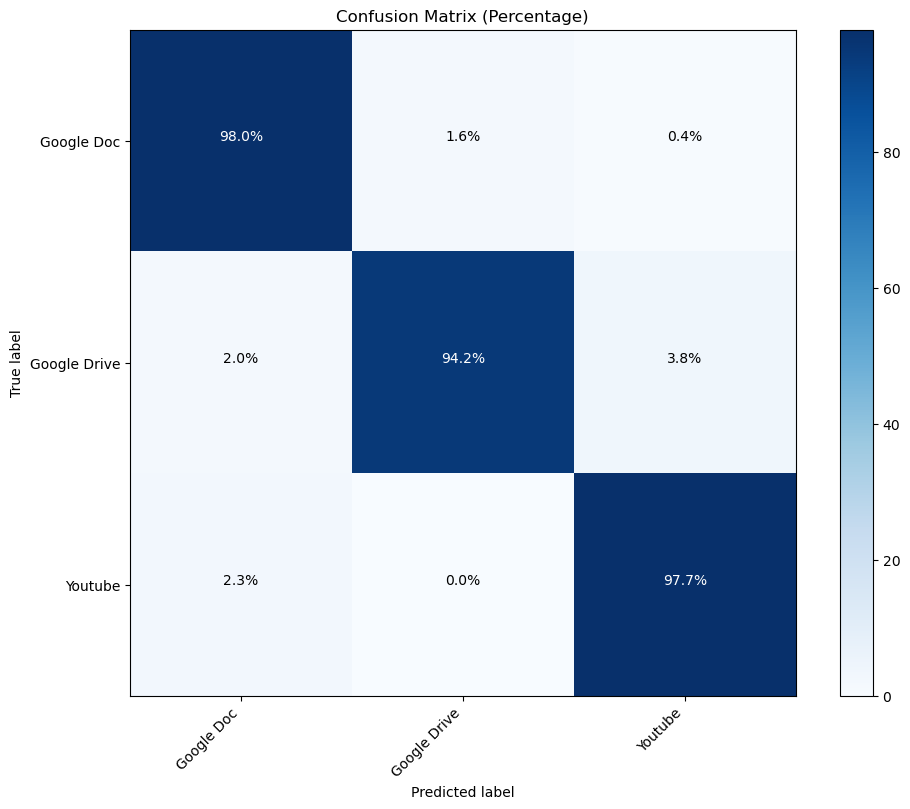


Evaluation Complete!
Total evaluation time: 0:00:04.085060
Val Accuracy: 97.04%

Creating confusion matrices...
Successfully saved: checkpoints/timesnet_classifier_confusion_matrix.png


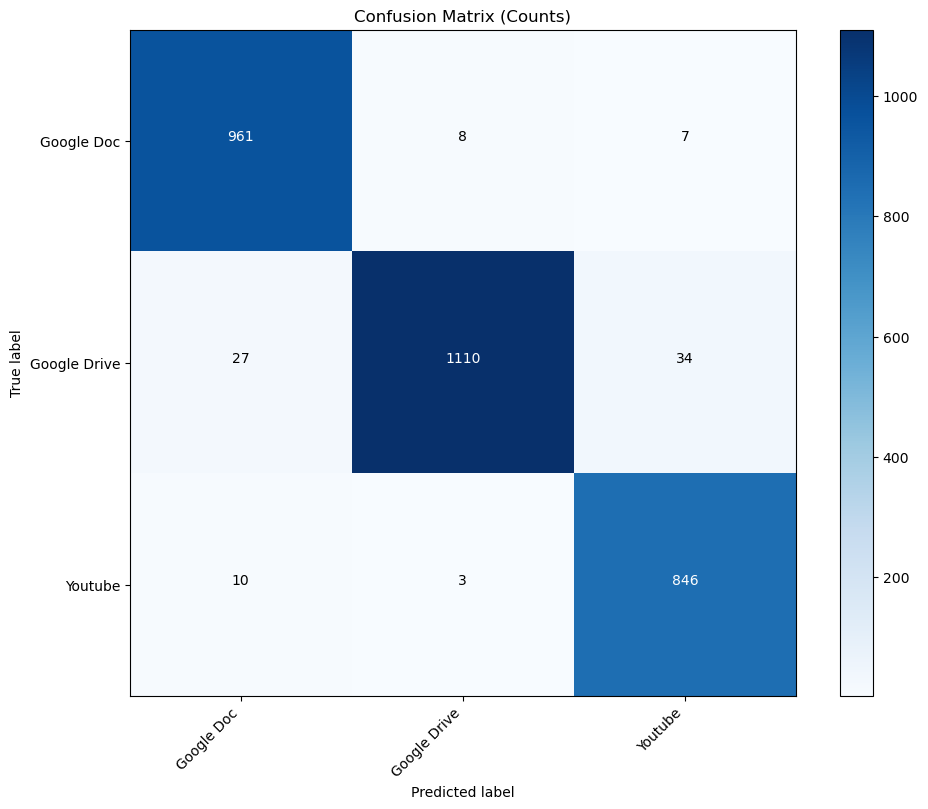

Successfully saved: checkpoints/timesnet_classifier_confusion_matrix_percent.png


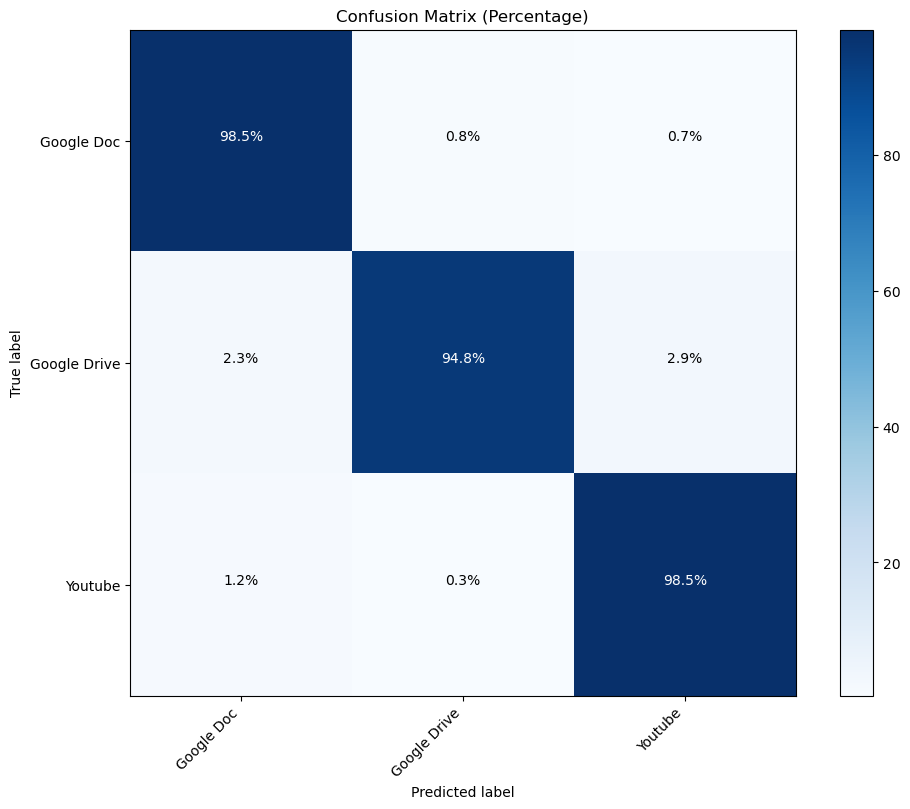


Evaluation Complete!
Total evaluation time: 0:00:15.611459

Processing dataset: 201


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Saving checkpoint to checkpoints/timesnet_classifier_best.pth


Training: 100%|██████████| 1/1 [00:13<00:00, 13.23s/it, train_loss=0.2744, train_acc=91.52%, val_loss=0.1080, val_acc=97.47%, time=0:00:13]

Successfully saved checkpoint
Epoch 1/1
Training Loss: 0.2744, Accuracy: 91.52%
Validation Loss: 0.1080, Accuracy: 97.47%
Epoch time: 0:00:13.227982
----------------------------------------

Training Complete!
Total training time: 0:00:13.242958

Plotting Training Metrics...
Saving metrics plot to: checkpoints/timesnet_classifier_training_metrics.png


Successfully saved metrics plot


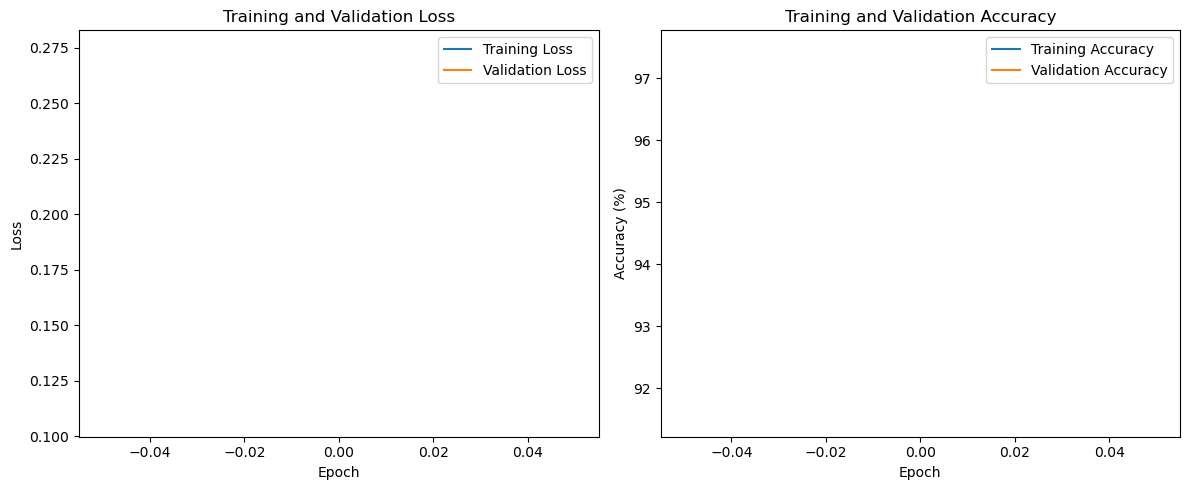

Val Accuracy: 97.47%

Creating confusion matrices...
Successfully saved: checkpoints/timesnet_classifier_confusion_matrix.png


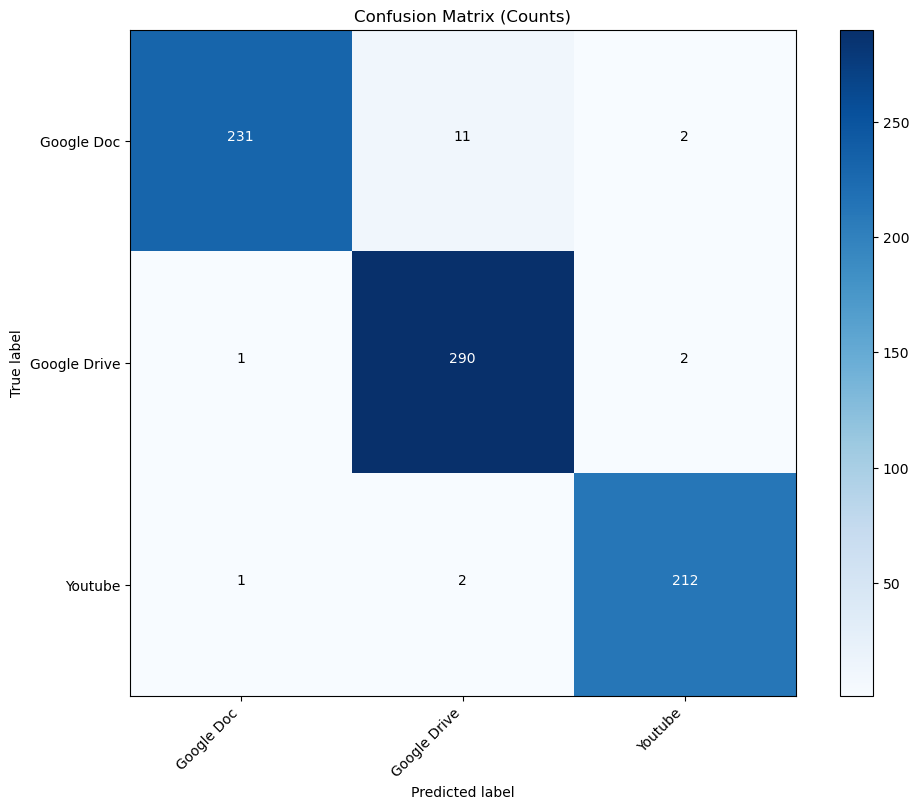

Successfully saved: checkpoints/timesnet_classifier_confusion_matrix_percent.png


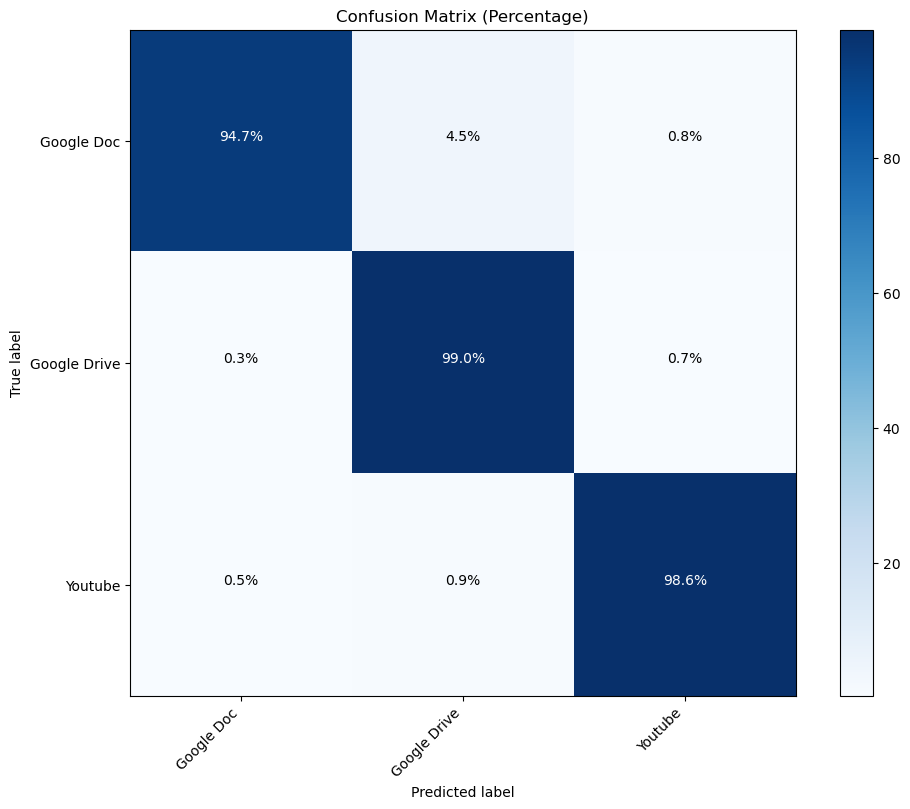


Evaluation Complete!
Total evaluation time: 0:00:00.801930
Val Accuracy: 96.51%

Creating confusion matrices...
Successfully saved: checkpoints/timesnet_classifier_confusion_matrix.png


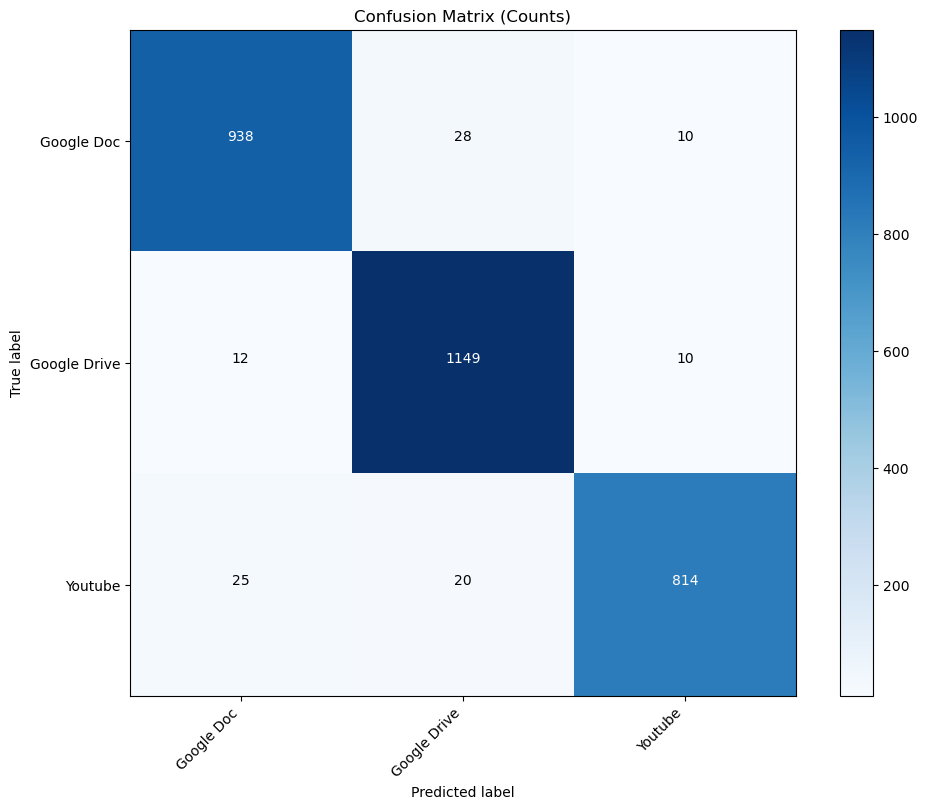

Successfully saved: checkpoints/timesnet_classifier_confusion_matrix_percent.png


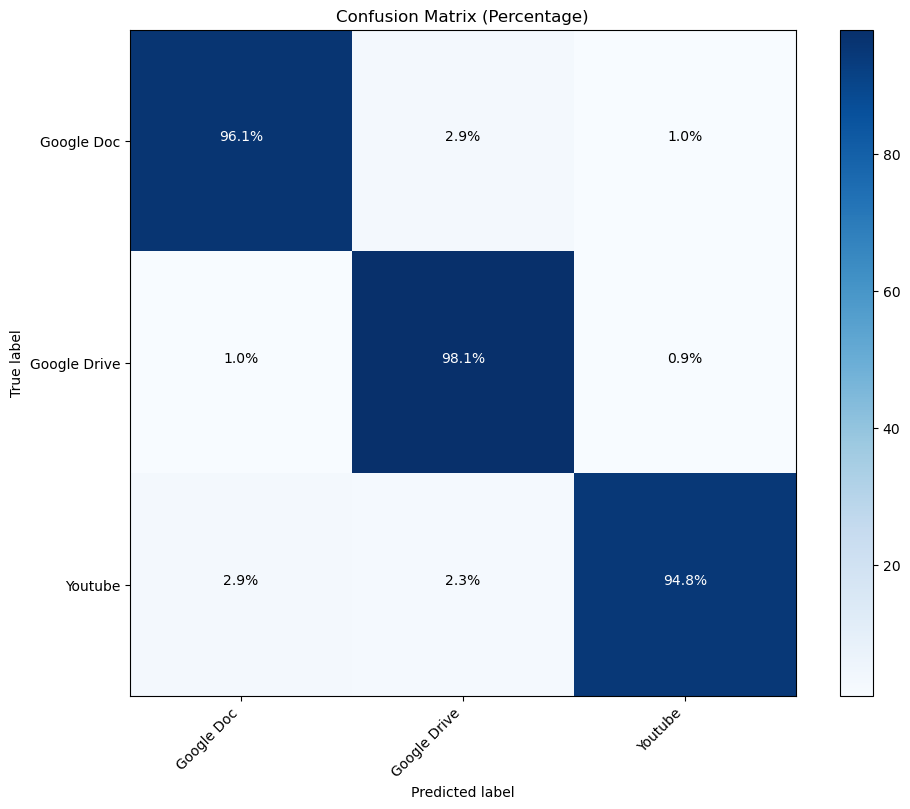


Evaluation Complete!
Total evaluation time: 0:00:02.422929

Processing dataset: 41


Training:   0%|          | 0/1 [00:00<?, ?it/s]

Saving checkpoint to checkpoints/timesnet_classifier_best.pth


Training: 100%|██████████| 1/1 [00:06<00:00,  6.57s/it, train_loss=0.2798, train_acc=92.05%, val_loss=0.0823, val_acc=98.01%, time=0:00:06]

Successfully saved checkpoint
Epoch 1/1
Training Loss: 0.2798, Accuracy: 92.05%
Validation Loss: 0.0823, Accuracy: 98.01%
Epoch time: 0:00:06.570291
----------------------------------------

Training Complete!
Total training time: 0:00:06.585339

Plotting Training Metrics...
Saving metrics plot to: checkpoints/timesnet_classifier_training_metrics.png


Successfully saved metrics plot


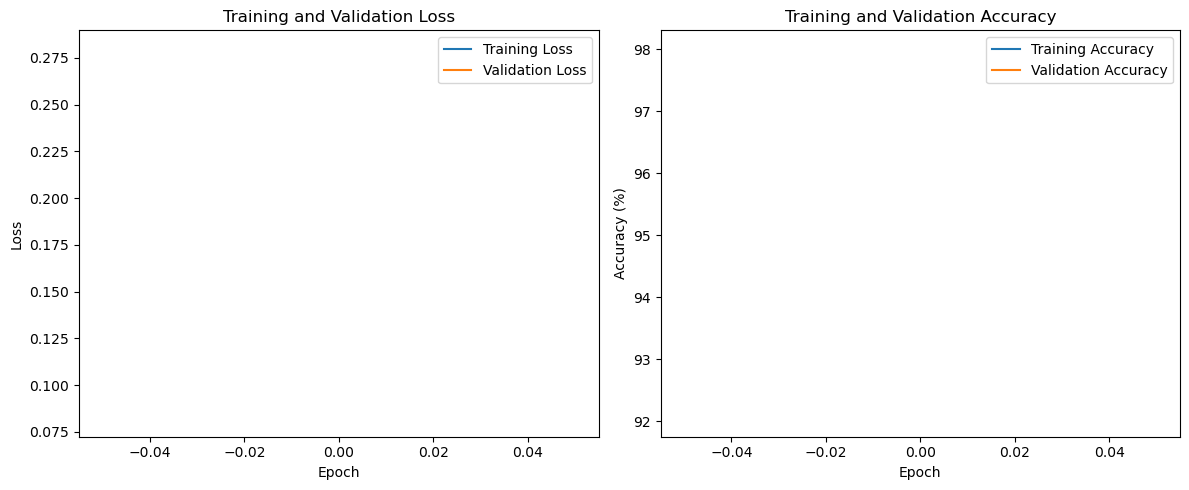

Val Accuracy: 98.01%

Creating confusion matrices...
Successfully saved: checkpoints/timesnet_classifier_confusion_matrix.png


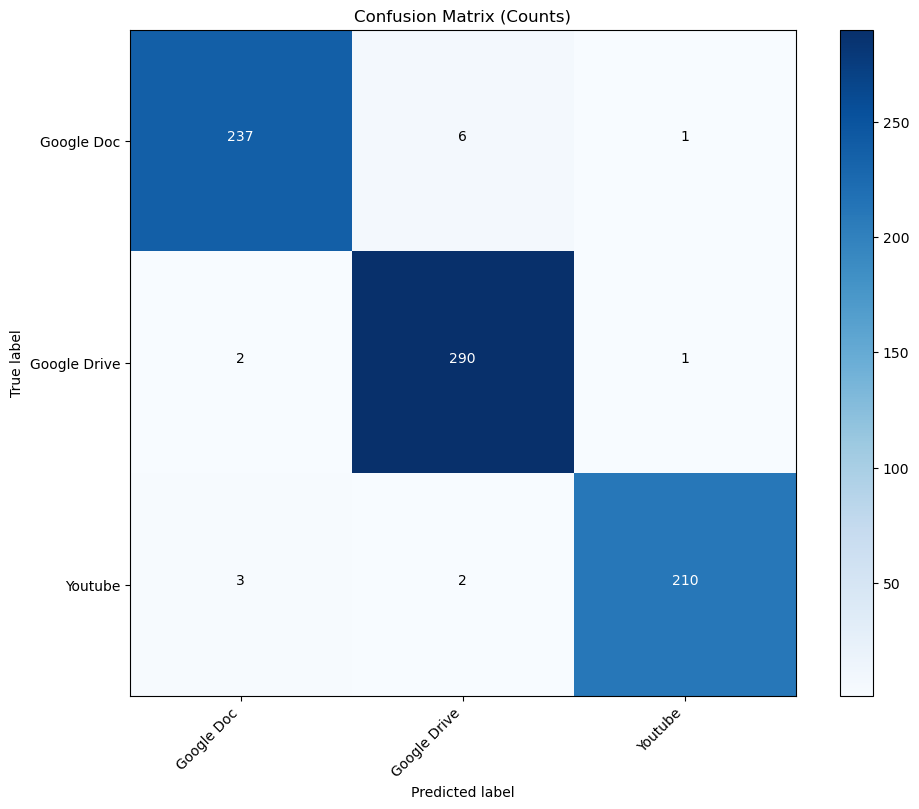

Successfully saved: checkpoints/timesnet_classifier_confusion_matrix_percent.png


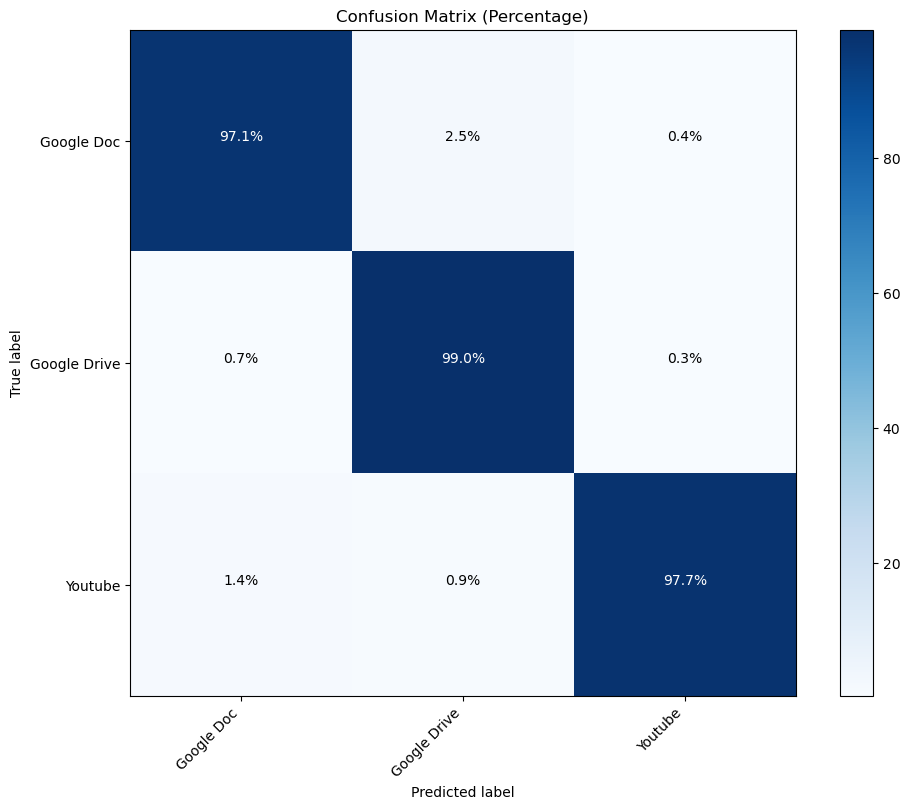


Evaluation Complete!
Total evaluation time: 0:00:00.518678
Val Accuracy: 97.74%

Creating confusion matrices...
Successfully saved: checkpoints/timesnet_classifier_confusion_matrix.png


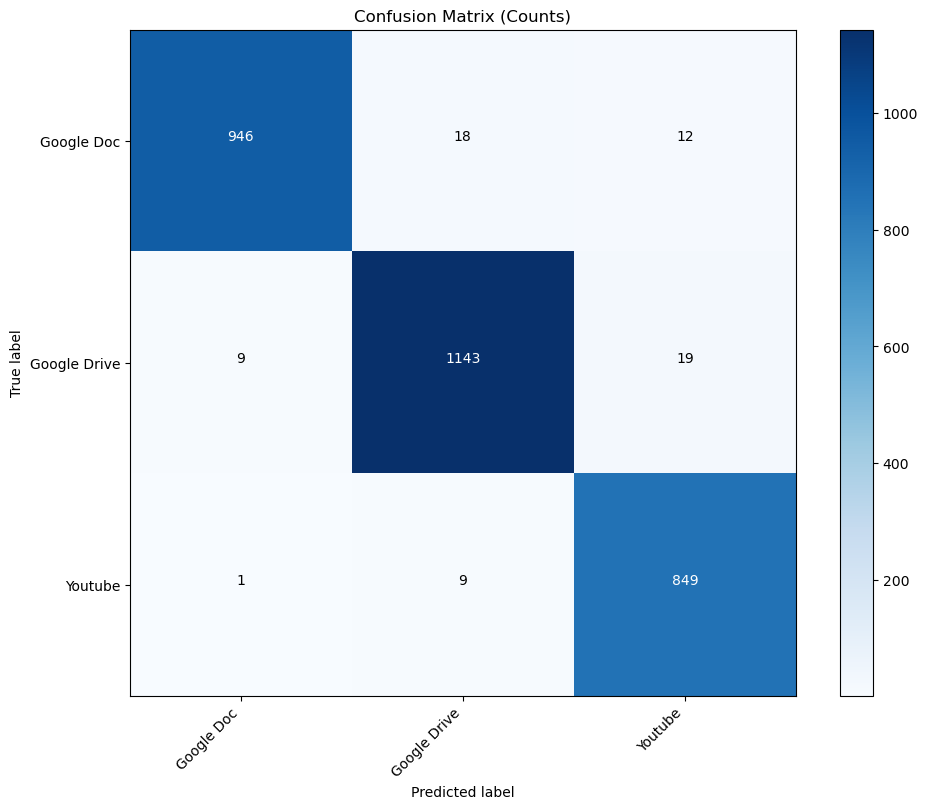

Successfully saved: checkpoints/timesnet_classifier_confusion_matrix_percent.png


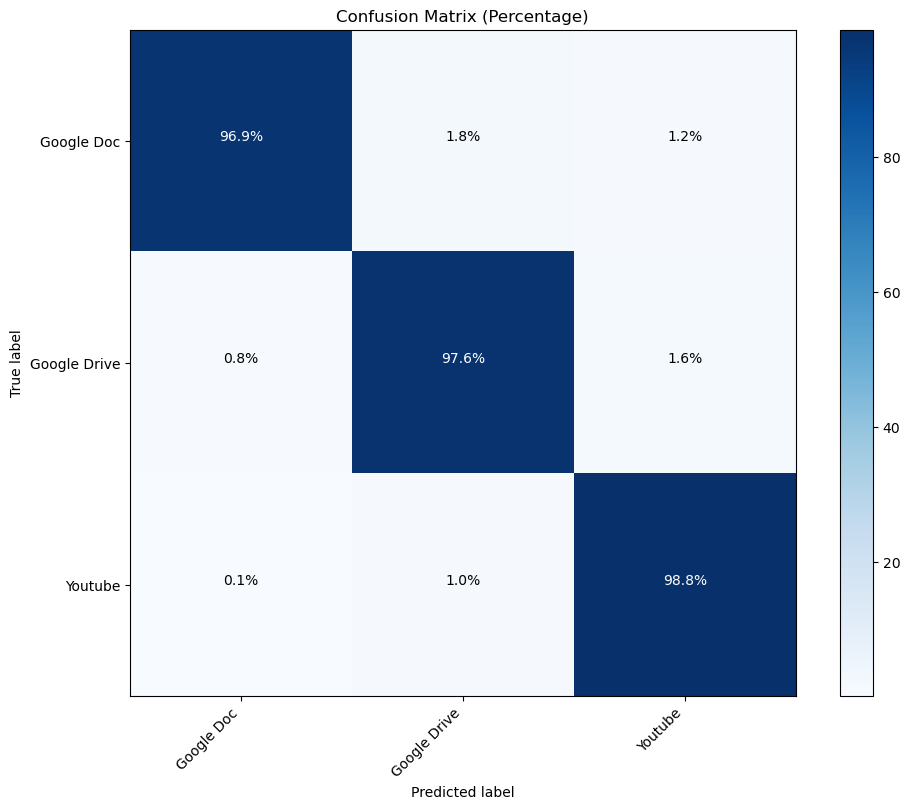


Evaluation Complete!
Total evaluation time: 0:00:01.210878

Results saved to:
Summary: results/model_comparison_summary_20250223_164026.csv
Detailed: results/model_comparison_detailed_20250223_164026.csv


In [16]:
model_types=['nst','informer','timesnet']
results = evaluate_models_on_datasets(datasets,model_types=model_types)

In [17]:
# For NST model
nst_model, nst_config = create_model(X,y,'nst')
nst_config.print_config()

NameError: name 'X' is not defined

In [42]:
# For TimesNet model
timesnet_model, timesnet_config = create_model(X,y,'timesnet')
timesnet_config.print_config()


Model Configuration:
--------------------------------------------------
task_name: classification
seq_len: 21
pred_len: 0
label_len: 0
enc_in: 1
dec_in: 1
c_out: 1
num_class: 5
dropout: 0.1
embed: timeF
freq: h
batch_size: 32
learning_rate: 0.0001
num_epochs: 10
use_gpu: False
checkpoint_dir: checkpoints
classes_names: ['Google Doc', 'Google Drive', 'Google Music', 'Google Search', 'Youtube']
d_model: 64
e_layers: 2
d_ff: 128
top_k: 3
num_kernels: 6
model_name: timesnet_classifier
--------------------------------------------------


In [43]:
informer_model, informer_config = create_model(X,y,'informer')
informer_config.print_config()


Model Configuration:
--------------------------------------------------
task_name: classification
seq_len: 21
pred_len: 0
label_len: 0
enc_in: 1
dec_in: 1
c_out: 1
num_class: 5
dropout: 0.05
embed: fixed
freq: h
batch_size: 32
learning_rate: 0.0001
num_epochs: 10
use_gpu: False
checkpoint_dir: checkpoints
classes_names: ['Google Doc', 'Google Drive', 'Google Music', 'Google Search', 'Youtube']
d_model: 512
n_heads: 8
e_layers: 3
d_layers: 2
d_ff: 2048
factor: 5
distil: True
activation: gelu
attn: prob
output_attention: False
mix: True
model_name: informer_classifier
--------------------------------------------------


In [44]:
# Train NST model
train_loader, val_loader = prepare_data(X, y, informer_config)

Epoch 1:  22%|██████████▍                                    | 32/144 [00:23<01:18,  1.43it/s, loss=0.2199, acc=78.22%]


Epoch 1:  45%|█████████████████████▏                         | 65/144 [00:45<00:53,  1.46it/s, loss=0.2797, acc=84.18%]


Epoch 1:  68%|███████████████████████████████▉               | 98/144 [01:07<00:30,  1.52it/s, loss=0.4120, acc=86.54%]


Epoch 1:  91%|█████████████████████████████████████████▊    | 131/144 [01:31<00:08,  1.46it/s, loss=0.2168, acc=88.26%]


Epoch 1: 100%|██████████████████████████████████████████████| 144/144 [01:40<00:00,  1.71it/s, loss=0.1180, acc=88.65%]
                                                                                                                       
Validation:  53%|███████████████████████▊                     | 19/36 [00:05<00:04,  4.22it/s, loss=0.2833, acc=94.08%]


Validation: 100%|█████████████████████████████████████████████| 36/36 [00:09<00:00,  4.58it/s, loss=0.0791, acc=94.25%]
                                                                                                                       

Saving checkpoint to checkpoints\informer_classifier_best.pth


Training:  10%| | 1/10 [01:50<16:33, 110.43s/it, train_loss=0.3592, train_acc=88.65%, val_loss=0.1806, val_acc=94.25%, 

Successfully saved checkpoint
Epoch 1/10
Training Loss: 0.3592, Accuracy: 88.65%
Validation Loss: 0.1806, Accuracy: 94.25%
Epoch time: 0:01:50.431861
----------------------------------------



Epoch 2:  22%|██████████▍                                    | 32/144 [00:23<01:21,  1.38it/s, loss=0.2869, acc=93.94%]


Epoch 2:  45%|█████████████████████▏                         | 65/144 [00:45<00:50,  1.57it/s, loss=0.1340, acc=93.61%]


Epoch 2:  68%|███████████████████████████████▉               | 98/144 [01:08<00:30,  1.53it/s, loss=0.3296, acc=93.69%]


Epoch 2:  91%|█████████████████████████████████████████▊    | 131/144 [01:31<00:08,  1.46it/s, loss=0.1639, acc=93.94%]


Epoch 2: 100%|██████████████████████████████████████████████| 144/144 [01:39<00:00,  1.80it/s, loss=0.3534, acc=94.12%]
                                                                                                                       
Validation:  53%|███████████████████████▊                     | 19/36 [00:05<00:03,  4.43it/s, loss=0.2664, acc=96.25%]


Validation: 100%|█████████████████████████████████████████████| 36/36 [00:09<00:00,  4.46it/s, loss=0.0158, acc=96.25%]
                                                                                                                       

Saving checkpoint to checkpoints\informer_classifier_best.pth


Training:  20%|▏| 2/10 [03:39<14:36, 109.50s/it, train_loss=0.1830, train_acc=94.12%, val_loss=0.1163, val_acc=96.25%, 

Successfully saved checkpoint
Epoch 2/10
Training Loss: 0.1830, Accuracy: 94.12%
Validation Loss: 0.1163, Accuracy: 96.25%
Epoch time: 0:01:48.848271
----------------------------------------



Epoch 3:  22%|██████████▍                                    | 32/144 [00:23<01:15,  1.49it/s, loss=0.1579, acc=94.70%]


Epoch 3:  45%|█████████████████████▏                         | 65/144 [00:45<00:52,  1.51it/s, loss=0.1299, acc=95.17%]


Epoch 3:  68%|███████████████████████████████▉               | 98/144 [01:08<00:29,  1.53it/s, loss=0.1191, acc=95.14%]


Epoch 3:  91%|█████████████████████████████████████████▊    | 131/144 [01:30<00:08,  1.50it/s, loss=0.2004, acc=95.36%]


Epoch 3: 100%|██████████████████████████████████████████████| 144/144 [01:38<00:00,  1.61it/s, loss=0.0915, acc=95.45%]
                                                                                                                       
Validation:  53%|███████████████████████▊                     | 19/36 [00:05<00:03,  4.36it/s, loss=0.2187, acc=95.31%]


Validation: 100%|█████████████████████████████████████████████| 36/36 [00:09<00:00,  4.35it/s, loss=0.0120, acc=95.64%]
Training:  30%|▎| 3/10 [05:27<12:41, 108.73s/it, train_loss=0.1344, train_acc=95.45%, val_loss=0.1228, val_acc=95.64%, 

Epoch 3/10
Training Loss: 0.1344, Accuracy: 95.45%
Validation Loss: 0.1228, Accuracy: 95.64%
Epoch time: 0:01:47.816529
----------------------------------------



Epoch 4:  22%|██████████▍                                    | 32/144 [00:24<01:21,  1.37it/s, loss=0.0683, acc=96.78%]


Epoch 4:  45%|█████████████████████▏                         | 65/144 [00:50<00:58,  1.34it/s, loss=0.1054, acc=96.83%]


Epoch 4:  68%|███████████████████████████████▉               | 98/144 [01:14<00:29,  1.54it/s, loss=0.1884, acc=96.21%]


Epoch 4:  91%|█████████████████████████████████████████▊    | 131/144 [01:38<00:08,  1.48it/s, loss=0.1627, acc=96.26%]


Epoch 4: 100%|██████████████████████████████████████████████| 144/144 [01:45<00:00,  1.79it/s, loss=0.2077, acc=96.23%]
                                                                                                                       
Validation:  53%|███████████████████████▊                     | 19/36 [00:06<00:04,  4.00it/s, loss=0.3439, acc=96.25%]


Validation: 100%|█████████████████████████████████████████████| 36/36 [00:10<00:00,  4.07it/s, loss=0.0083, acc=96.25%]
Training:  40%|▍| 4/10 [07:23<11:10, 111.83s/it, train_loss=0.1148, train_acc=96.23%, val_loss=0.1184, val_acc=96.25%, 

Epoch 4/10
Training Loss: 0.1148, Accuracy: 96.23%
Validation Loss: 0.1184, Accuracy: 96.25%
Epoch time: 0:01:56.566653
----------------------------------------



Epoch 5:  22%|██████████▍                                    | 32/144 [00:23<01:16,  1.47it/s, loss=0.1022, acc=97.73%]


Epoch 5:  45%|█████████████████████▏                         | 65/144 [00:47<01:01,  1.29it/s, loss=0.0368, acc=97.54%]


Epoch 5:  68%|███████████████████████████████▉               | 98/144 [01:11<00:34,  1.33it/s, loss=0.1466, acc=97.60%]


Epoch 5:  91%|█████████████████████████████████████████▊    | 131/144 [01:35<00:09,  1.32it/s, loss=0.2244, acc=97.30%]


Epoch 5: 100%|██████████████████████████████████████████████| 144/144 [01:44<00:00,  1.62it/s, loss=0.0457, acc=97.25%]
                                                                                                                       
Validation:  53%|███████████████████████▊                     | 19/36 [00:05<00:03,  4.34it/s, loss=0.1593, acc=96.25%]


Validation: 100%|█████████████████████████████████████████████| 36/36 [00:09<00:00,  4.00it/s, loss=0.0116, acc=95.73%]
                                                                                                                       

Saving checkpoint to checkpoints\informer_classifier_epoch_5.pth


Training:  50%|▌| 5/10 [09:17<09:23, 112.72s/it, train_loss=0.0874, train_acc=97.25%, val_loss=0.1176, val_acc=95.73%, 

Successfully saved checkpoint
Epoch 5/10
Training Loss: 0.0874, Accuracy: 97.25%
Validation Loss: 0.1176, Accuracy: 95.73%
Epoch time: 0:01:54.310941
----------------------------------------



Epoch 6:  22%|██████████▍                                    | 32/144 [00:23<01:16,  1.46it/s, loss=0.0253, acc=97.92%]


Epoch 6:  45%|█████████████████████▏                         | 65/144 [00:45<00:51,  1.52it/s, loss=0.0050, acc=98.06%]


Epoch 6:  68%|███████████████████████████████▉               | 98/144 [01:08<00:33,  1.39it/s, loss=0.0389, acc=98.04%]


Epoch 6:  91%|█████████████████████████████████████████▊    | 131/144 [01:31<00:08,  1.45it/s, loss=0.0545, acc=97.73%]


Epoch 6: 100%|██████████████████████████████████████████████| 144/144 [01:40<00:00,  1.70it/s, loss=0.0788, acc=97.69%]
                                                                                                                       
Validation:  53%|███████████████████████▊                     | 19/36 [00:05<00:03,  4.26it/s, loss=0.3540, acc=94.53%]


Validation: 100%|█████████████████████████████████████████████| 36/36 [00:09<00:00,  4.01it/s, loss=0.0160, acc=95.38%]
Training:  60%|▌| 6/10 [11:07<07:26, 111.62s/it, train_loss=0.0715, train_acc=97.69%, val_loss=0.1347, val_acc=95.38%, 

Epoch 6/10
Training Loss: 0.0715, Accuracy: 97.69%
Validation Loss: 0.1347, Accuracy: 95.38%
Epoch time: 0:01:49.481193
----------------------------------------



Epoch 7:  22%|██████████▍                                    | 32/144 [00:23<01:20,  1.40it/s, loss=0.0206, acc=97.92%]


Epoch 7:  45%|█████████████████████▏                         | 65/144 [00:47<00:57,  1.37it/s, loss=0.0324, acc=98.44%]


Epoch 7:  68%|███████████████████████████████▉               | 98/144 [01:11<00:32,  1.43it/s, loss=0.0521, acc=98.45%]


Epoch 7:  91%|█████████████████████████████████████████▊    | 131/144 [01:34<00:09,  1.34it/s, loss=0.1234, acc=98.20%]


Epoch 7: 100%|██████████████████████████████████████████████| 144/144 [01:42<00:00,  1.60it/s, loss=0.0054, acc=98.13%]
                                                                                                                       
Validation:  53%|███████████████████████▊                     | 19/36 [00:05<00:03,  4.36it/s, loss=0.1697, acc=97.50%]


Validation: 100%|█████████████████████████████████████████████| 36/36 [00:08<00:00,  4.74it/s, loss=0.0021, acc=96.78%]
                                                                                                                       

Saving checkpoint to checkpoints\informer_classifier_best.pth


Training:  70%|▋| 7/10 [12:59<05:35, 111.77s/it, train_loss=0.0645, train_acc=98.13%, val_loss=0.0897, val_acc=96.78%, 

Successfully saved checkpoint
Epoch 7/10
Training Loss: 0.0645, Accuracy: 98.13%
Validation Loss: 0.0897, Accuracy: 96.78%
Epoch time: 0:01:52.073074
----------------------------------------



Epoch 8:  22%|██████████▍                                    | 32/144 [00:23<01:16,  1.46it/s, loss=0.0639, acc=98.96%]


Epoch 8:  45%|█████████████████████▏                         | 65/144 [00:46<00:48,  1.64it/s, loss=0.0819, acc=98.77%]


Epoch 8:  68%|███████████████████████████████▉               | 98/144 [01:09<00:33,  1.38it/s, loss=0.0960, acc=98.64%]


Epoch 8:  91%|█████████████████████████████████████████▊    | 131/144 [01:32<00:08,  1.51it/s, loss=0.0172, acc=98.53%]


Epoch 8: 100%|██████████████████████████████████████████████| 144/144 [01:40<00:00,  1.62it/s, loss=0.0141, acc=98.54%]
                                                                                                                       
Validation:  53%|███████████████████████▊                     | 19/36 [00:05<00:04,  4.25it/s, loss=0.2437, acc=97.03%]


Validation: 100%|█████████████████████████████████████████████| 36/36 [00:09<00:00,  4.31it/s, loss=0.0022, acc=97.13%]
                                                                                                                       

Saving checkpoint to checkpoints\informer_classifier_best.pth


Training:  80%|▊| 8/10 [14:49<03:42, 111.22s/it, train_loss=0.0518, train_acc=98.54%, val_loss=0.0815, val_acc=97.13%, 

Successfully saved checkpoint
Epoch 8/10
Training Loss: 0.0518, Accuracy: 98.54%
Validation Loss: 0.0815, Accuracy: 97.13%
Epoch time: 0:01:50.041909
----------------------------------------



Epoch 9:  22%|██████████▍                                    | 32/144 [00:23<01:15,  1.49it/s, loss=0.0361, acc=99.15%]


Epoch 9:  45%|█████████████████████▏                         | 65/144 [00:45<00:53,  1.46it/s, loss=0.3193, acc=98.53%]


Epoch 9:  68%|███████████████████████████████▉               | 98/144 [01:08<00:33,  1.38it/s, loss=0.0572, acc=98.58%]


Epoch 9:  91%|█████████████████████████████████████████▊    | 131/144 [01:31<00:09,  1.41it/s, loss=0.1314, acc=98.53%]


Epoch 9: 100%|██████████████████████████████████████████████| 144/144 [01:39<00:00,  1.74it/s, loss=0.0158, acc=98.54%]
                                                                                                                       
Validation:  53%|███████████████████████▊                     | 19/36 [00:06<00:04,  4.16it/s, loss=0.2400, acc=95.78%]


Validation: 100%|█████████████████████████████████████████████| 36/36 [00:09<00:00,  4.28it/s, loss=0.0018, acc=95.82%]
Training:  90%|▉| 9/10 [16:38<01:50, 110.61s/it, train_loss=0.0478, train_acc=98.54%, val_loss=0.1085, val_acc=95.82%, 

Epoch 9/10
Training Loss: 0.0478, Accuracy: 98.54%
Validation Loss: 0.1085, Accuracy: 95.82%
Epoch time: 0:01:49.257053
----------------------------------------



Epoch 10:  22%|██████████▏                                   | 32/144 [00:23<01:14,  1.50it/s, loss=0.0392, acc=98.30%]


Epoch 10:  45%|████████████████████▊                         | 65/144 [00:47<00:53,  1.47it/s, loss=0.2166, acc=98.53%]


Epoch 10:  68%|███████████████████████████████▎              | 98/144 [01:09<00:31,  1.45it/s, loss=0.0047, acc=98.45%]


Epoch 10:  91%|████████████████████████████████████████▉    | 131/144 [01:31<00:09,  1.42it/s, loss=0.0529, acc=98.51%]


Epoch 10: 100%|█████████████████████████████████████████████| 144/144 [01:39<00:00,  1.85it/s, loss=0.0303, acc=98.58%]
                                                                                                                       
Validation:  53%|███████████████████████▊                     | 19/36 [00:05<00:03,  4.36it/s, loss=0.2248, acc=97.03%]


Validation: 100%|█████████████████████████████████████████████| 36/36 [00:09<00:00,  3.83it/s, loss=0.0011, acc=96.69%]
                                                                                                                       

Saving checkpoint to checkpoints\informer_classifier_epoch_10.pth


Training: 100%|█| 10/10 [18:28<00:00, 110.90s/it, train_loss=0.0452, train_acc=98.58%, val_loss=0.0963, val_acc=96.69%,

Successfully saved checkpoint
Epoch 10/10
Training Loss: 0.0452, Accuracy: 98.58%
Validation Loss: 0.0963, Accuracy: 96.69%
Epoch time: 0:01:50.105901
----------------------------------------

Training Complete!
Total training time: 0:18:29.133364

Plotting Training Metrics...


Saving metrics plot to: checkpoints\informer_classifier_training_metrics.png
Successfully saved metrics plot


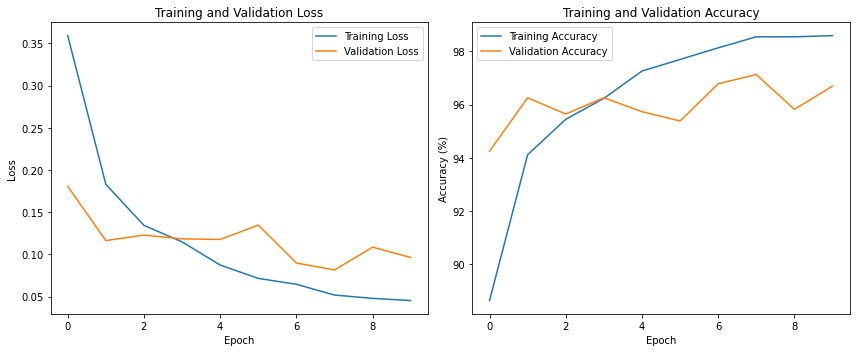

Val Accuracy: 97.65%

Creating confusion matrix...
Saving confusion matrix to: checkpoints\informer_classifier_confusion_matrix.png
Successfully saved confusion matrix


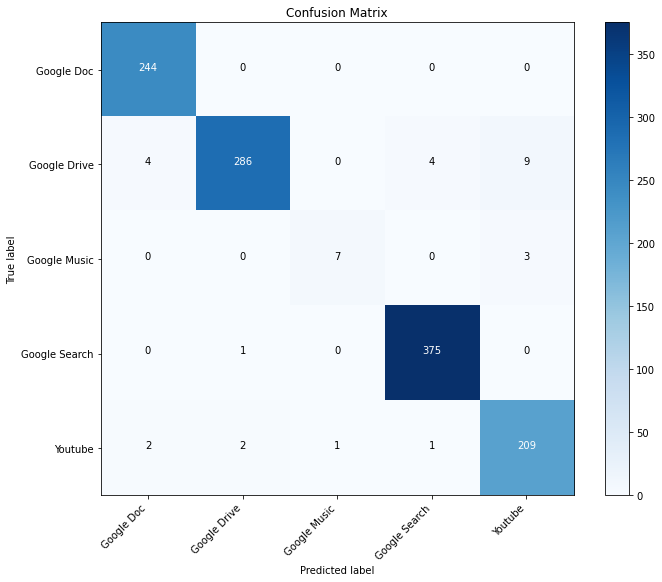


Evaluation Complete!
Total evaluation time: 0:00:09.251241


In [45]:
informer_model, informer_best_val_acc = train_classifier(train_loader, val_loader, informer_config)

In [ ]:
nst_model, nst_best_val_acc = train_classifier(train_loader, val_loader, nst_config)

Saving checkpoint to checkpoints\timesnet_classifier_best.pth
Successfully saved checkpoint
Epoch 1/10
Training Loss: 0.4676, Accuracy: 85.14%
Validation Loss: 0.2393, Accuracy: 92.16%
Epoch time: 0:08:37.344450
----------------------------------------
Saving checkpoint to checkpoints\timesnet_classifier_best.pth
Successfully saved checkpoint
Epoch 2/10
Training Loss: 0.2304, Accuracy: 93.57%
Validation Loss: 0.1788, Accuracy: 93.21%
Epoch time: 0:07:50.244821
----------------------------------------
Saving checkpoint to checkpoints\timesnet_classifier_best.pth
Successfully saved checkpoint
Epoch 3/10
Training Loss: 0.1706, Accuracy: 95.03%
Validation Loss: 0.1464, Accuracy: 95.82%
Epoch time: 0:08:17.906183
----------------------------------------
Saving checkpoint to checkpoints\timesnet_classifier_best.pth
Successfully saved checkpoint
Epoch 4/10
Training Loss: 0.1217, Accuracy: 96.77%
Validation Loss: 0.1254, Accuracy: 96.08%
Epoch time: 0:08:35.905704
-----------------------------

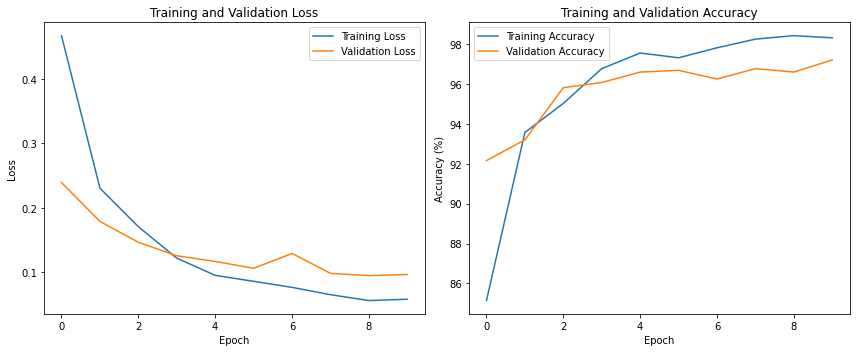

Val Accuracy: 97.21%

Creating confusion matrix...
Saving confusion matrix to: checkpoints\timesnet_classifier_confusion_matrix.png
Successfully saved confusion matrix


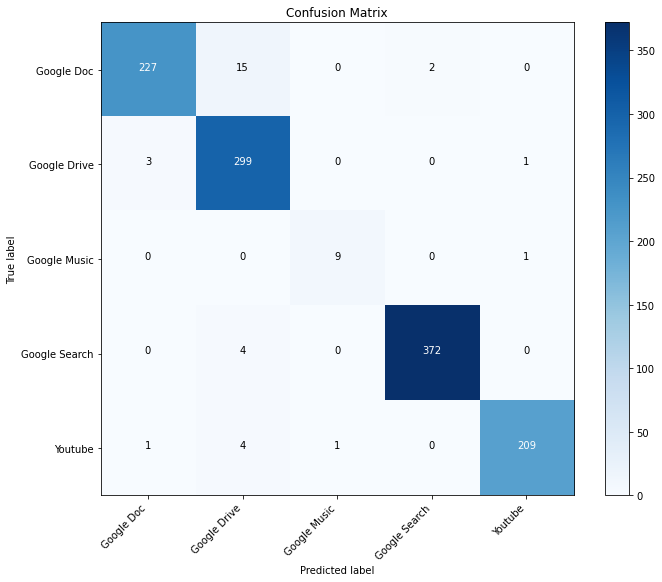


Evaluation Complete!
Total evaluation time: 0:00:37.352484


In [17]:
timesnet_model, timesnet_best_val_acc = train_classifier(train_loader, val_loader, timesnet_config, model=timesnet_model)